<a href="https://colab.research.google.com/github/RubenMcCarty/Data-Analysis-Python/blob/main/data_driven_lingerie_shopping_RubenQuispe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_"If love is blind, why is lingerie so popular?" (c) Dorothy Parker_


# Data-driven lingerie shopping


This is a detailed analysis of [lingerie dataset](https://www.kaggle.com/PromptCloudHQ/innerwear-data-from-victorias-secret-and-others) published on kaggle. It was created by extracting data from the popular retail sites via PromptCloud's data extraction solutions in June, 2017 to July, 2017.

Websites and brands covered in this analysis:

* Victoria's Secret (official website and Amazon)<br>
* Wacoal aka Btemptd (official website, Amazon and Macy's <br>
* Calvin Klein (official website, Amazon and Macy's) <br>
* Hanky Panky (official website, Amazon and Macy's<br>
* Topshop USA<br>

**Main questions:**

1. What kind of products are offered by each brand and what are their most expensive items?
2. Which brands offer low-priced panties, bras, bralettes etc?
3. Which brand offers a larger percentage discount?
4. Which brand offers a larger absolute discount?


I will happy to hear some remarks or suggestions and feel free to upvote if you like it :)

NB2: Cleaning of the data took most of the analysis time.

# Load data

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import numpy as np
# to normalize the strings
import unicodedata
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 1000)

pals = sns.hls_palette(8, l=.3, s=.8)
purple = sns.cubehelix_palette(11)
light_purple = sns.light_palette("purple",n_colors=8)
pink = sns.color_palette("husl", 8)[7]
sns.set_palette(pals)
fig_size=[12,9]
sns.set(font_scale = 1.4)
sns.set_style('white', {'legend.frameon':True})
#sns.set_style("white")
plt.rcParams["figure.figsize"] = fig_size

In [ ]:
brands_info = pd.read_csv('../input/cleaned-lingerie-data-from-different-brands/cleaned_data.csv')

# 1. Variety of products
## 1.1 Products by names

We will explore the number of products offered by each brand.

**Questions:**
1. What is the amount of products of each brand.
2. How many unique products are there? Does Victoria's Secret really offers more unique products or there are only several products with a tremendous amount of different colors?

In [ ]:
brands_name = ['Calvin Klein','Hanky Panky',"Victoria's Secret", 'Topshop', 'Wacoal', 'Amazon Calvin Klein',
               'Amazon Hanky Panky', "Amazon Victoria's Secret", 'Amazon Wacoal',
               'Macys Calvin Klein', 'Macys Hanky Panky', 'Macys Wacoal']

df = brands_info.groupby('brand').product_name.agg(['count', 'nunique'])
df = df.loc[brands_name]
df.rename(columns={'count':'Number of products (colors)', 'nunique': 'Number of unique models' })

Number of products (colors)  Number of unique models
brand                                                                         
Calvin Klein              448                          108                    
Hanky Panky               637                          294                    
Victoria's Secret         3519                         455                    
Topshop                   421                          287                    
Wacoal                    377                          74                     
Amazon Calvin Klein       126                          36                     
Amazon Hanky Panky        20                           3                      
Amazon Victoria's Secret  9                            1                      
Amazon Wacoal             39                           6                      
Macys Calvin Klein        659                          204                    
Macys Hanky Panky         280                          123                    
Macys Wacoal              573                          171

We know that there are 2 different products under the same name and color but different descriptions in Victoria's Secret, 2 in calvin Klein and 2 in Amazon Victoria's Secret. Due to such a small number it should not interfere with the downstream analysis.

Answers:

* Victoria's Secret offers the largest number of products. Amazon's Victoria's Secret offers quite a small number of products.
* The number of products of Calvin Klein official website is more than on Amazon and but less than on Macy's.
* The number of unique products on Amazon for all brands is pretty small between 36 and 1.
* Macys of Calvin Klein and Wacoal has more prodoct than the OW.

However, there are only 455 unique product names of Victoria's Secreat. That means that such a great number of products (3.5K) is due to the fact that the brand offers a huge variety of different colors. Isnt that what all woman want ? ;). 

**Question: 3**. What is actually that one product of Victoria's Secret that is sold by Amazon?

In [ ]:
print(brands_info[brands_info['brand']=="Amazon Victoria's Secret"].product_name.iloc[1])

## 1.2 What nice products do the brands offer?

It is interesting to distinguish the prices according to the product category of each brand to see if all products of one brand are expensive or only some of them. Calvin Klein and Hanky Panky have only several categories, whereas Victoria's Secreat is a bit of a mess. We will try to generalize the te product category by looking at the url of the product and product category itself and search for some keywords.

Several definitions that I did not know: <br>
“A bralette is an unstructured bra. It’s usually unlined, unpadded, wire-free” (c) Cora Harrington <br>
"A babydoll is a short, sometimes sleeveless, loose-fitting nightgown or negligee intended ..." (c) wiki. 

We will assume that chemise and babydoll is the same type of category.

There is a quite interesting trend in bralettes, so we will distinguish it from the bra.

Some of the Victoria's Secret bras have bodys in the product name.

Bras are considered to be all bras except for the sport bras. Sport bras are in the active wear category.

In [ ]:
def manipul_regex(str_array):
    string = "|".join(str_array)
    return "(^|\s)(" + string + ")(\s|$)"

def categorize(data):
    panties = manipul_regex(["thong","g string","pant","v kini","boypant","pants","panty","thongs","panties",
                             "ladypant","knickers","thong","twist knicker","brief","boyshort",
                             "lace v front short","signature lace bike short","side tie bikini",
                             "signature lace string bikini","tanga","panty","hipster","vikini","b.sleek bikini",
                             "b.sultry bikini","b.sumptuous bikini","b.tempt'd lace kiss bikini",
                             "cheekster", 'boypants','ladypants', 'boyshorts', 'hiphugger', 
                             'pink high leg logo bikini', 'pink shortie', 'pink logo bikini',
                             'lace sexy shortie', 'body base shorty', 'b.splendid bikini'
                            ])  
    
    bodys = manipul_regex(["bodysuit","teddy","wink plaything"])
    bras = manipul_regex(["bra","bustier","strapless","balconette","bandeau",
                          'pink palm lace strappy push up','body by victoria unlined demi', 
                          'pink daisy lace racerback push up', 
                          'pink wildflower lace high neck push up',
                          'pink wear everywhere super push', 'pink seamless lightly lined racerback',
                          'body by wacoal seamless underwire','basic beauty wireless contour',
                          'pink lace lightly lined triangle', 'lace cross front unlined halter'
                            ])
    
    activewear = manipul_regex(['sports bra', 'sport bra', 'sport bralette', 'sports bralette'])
    suspenders = manipul_regex(["suspenders","belt"])
    bralettes = manipul_regex(["bralettes","bralette", 'bralet'])
    tops = manipul_regex(["tops","top"])
    babydoll = manipul_regex(["babydoll","camisole and bikini set by bluebella","chemise"])
    shorts = manipul_regex(["short","shorts","chiffon tap pant"])
    socks = manipul_regex(["socks"])
    pack = manipul_regex(["pack"])
    maternity = manipul_regex(["maternity"])
    basque = manipul_regex(["basque"])
    slip = manipul_regex(["slip"])
    bralette = manipul_regex(["bralette","bralettes"])
    garter = manipul_regex(["garter"])
    robe = manipul_regex(["robe", "kimonos","kimono"])
    camisole = manipul_regex(["camisole","cami","tank"])
    shapers = manipul_regex(["bike short","shaper","bodybriefer"])
    eyemask = manipul_regex(["eyemask"])
    hoodie = manipul_regex(["hoodie"])
    sleepwear = manipul_regex(["pajama","sleep set","sleepwear","modern cotton lounge pants"])
    rompers = manipul_regex(["romper"]) 
    
    dict_cats = [['hoodie',hoodie],['eyemask', eyemask],[ 'shapers',shapers],
                 [ 'garter', garter],['bralette',bralette],
                 ['slip',slip],[ 'basque',basque],['maternity',maternity],
                 ['pack',pack],['socks',socks],['shorts',shorts],['robe', robe],
                 ['tops',tops],
                 ['suspenders',suspenders],['rompers', rompers],
                 ['bras',bras],['panties',panties], ['babydoll', babydoll],
                 ['bodys',bodys],['sleepwear', sleepwear],['bralettes', bralettes], ['activewear', activewear]
                ]
    #because there is a babydool with g-string and teddy with thong

    
    data.loc[(data['brand'].str.contains('Macys')), 'product_category_gen'] = 'Other'
    data.loc[(data['brand']== "Victoria's Secret"), 'product_category_gen'] = 'Other'
    data.loc[(data['brand']== "Hanky Panky"), 'product_category_gen'] = 'Other'
    
    dict_cats_pro = [['camisoles',camisole]]
    for items in dict_cats_pro:
        naming, reg = items
        data.loc[(data['product_name'].str.contains(reg, case=False)), 'product_category_gen'] = naming
        data.loc[(data['description'].str.contains(reg, case=False)), 'product_category_gen'] = naming

    for items in dict_cats:
        naming, reg = items
        data.loc[(data['product_name'].str.contains(reg, case=False)), 'product_category_gen'] = naming
    
    #data.loc[(data['description'].str.contains('bralette|bralettes', case=False))&(data['product_name'].str.contains('bra')), 'product_category_gen'] = 'bralettes'

    #data.loc[(data['brand']== "Calvin Klein")&(data['product_name'].str.contains('hoodie', case=False)), 'product_category_gen'] = 'hoodie'        
    data.loc[(data['brand'].str.contains("Macys"))&(data['product_name'].str.contains('bikini', case=False)), 'product_category_gen'] = 'panties'
    data.loc[(data['brand']== "Victoria's Secret")&(data['product_name'].str.contains('dream angels new! lace-up pleated slip', case=False)), 'product_category_gen'] = 'babydoll'
    data.loc[(data['brand']== "Victoria's Secret")&(data['product_name'].str.contains('very sexy lace plunge garter slip', case=False)), 'product_category_gen'] = 'babydoll'
    #data.loc[(data['brand']== "Victoria's Secret")&(data['pdp_url'].str.contains('swim', case=False)), 'product_category_gen'] = 'swimsuits'
    data.loc[(data['descr_conc'].str.contains('bralette|bralettes'))&(data['product_name'].str.contains('bandeau', case=False)), 'product_category_gen'] = 'bralettes'

    data.loc[(data['brand']== "Victoria's Secret")&(data['pdp_url'].str.contains('activewear', case=False)), 'product_category_gen'] = 'activewear'
    data.loc[(data['pdp_url'].str.contains('swim', case=False)), 'product_category_gen'] = 'swimsuits'
    data.loc[(data['descr_conc'].str.contains('swim', case=False)), 'product_category_gen'] = 'swimsuits'

    data.loc[(data['brand']== "Calvin Klein")&(data['pdp_url'].str.contains('activewear', case=False)), 'product_category_gen'] = 'activewear'

    data['product_category_gen'] = data['product_category_gen'].apply(lambda x: x.replace("women - lingerie & shapewear - ", ""))

    data.loc[(data['brand']== "Topshop")&(data['product_name'].str.contains('calvin klein', case=False)), 'product_category_gen'] = 'calvin klein'
    data.loc[(data['brand']== "Topshop")&(data['pdp_url'].str.contains('body', case=False)), 'product_category_gen'] = 'bodys'


    data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains(manipul_regex(['top|crop']), case=False)), 'product_category_gen'] = 'bras'
    data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains('bikini', case=False)), 'product_category_gen'] = 'panties'
    data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains('slip', case=False)), 'product_category_gen'] = 'slip'
    data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains('t-shirt', case=False)), 'product_category_gen'] = 'camisoles'
    #data.loc[(data['brand']== "Hanky Panky")&(data['descr_conc'].str.contains('panty', case=False)), 'product_category_gen'] = 'panties'


    data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains('low rise thong rose bouquet of|original rise thong rose bouquet of', case=False)), 'product_category_gen'] = 'pack'
    #data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains('low rise thong rose bouquet of 12', case=False)), 'product_category_gen'] = 'pack'
    #data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains('original rise thong rose bouquet of 6', case=False)), 'product_category_gen'] = 'pack'
    #data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains('original rise thong rose bouquet of 12', case=False)), 'product_category_gen'] = 'pack'
    data.loc[(data['product_name'].str.contains(manipul_regex(['pack', 'kiss packaged']), case=False)), 'product_category_gen'] = 'pack'

    #data.loc[(data['product_category'].str.contains('panty sets', case=False)), 'product_category_gen'] = 'panty sets'
    #data.loc[(data['brand']== "Victoria's Secret")&(data['product_category'].str.contains('cami & short set', case=False)), 'product_category_gen'] = 'sleep shorts & top'

    #['widow and thong', 'sultry balconette bra, thong and garter belt']
    #bra_panties_set = ['widow & thong', 'bahama mama lace',
    #                   'bra &','b.sultry balconette bra, thong and garter belt',
    #                   '^(?=.*bra)(?=.*(bikini|panty|tanga|hipster|thong|short|trunk|high cut brief|knickers))']
    #data.loc[(data['product_category'].str.contains('lingerie sets', case=False)), 'product_category_gen'] = 'bra panties sets'
    data.loc[(data['descr_conc'].str.contains('widow and thong', case=False)), 'product_category_gen'] = 'bra panties sets'


    data.loc[(data['product_name'].str.contains('sleeve top', case=False)), 'product_category_gen'] = 'tops'
    data.loc[(data['product_name'].str.contains('sleep set', case=False)), 'product_category_gen'] = 'sleepwear'
    data.loc[(data['product_category'].str.contains('sleepwear'))&(data['pdp_url'].str.contains('sleepwear', case=False)), 'product_category_gen'] = 'sleepwear'
    data.loc[(data['brand']=="Victoria's Secret")&(data['product_name'].isin(['pink wear everywhere t shirt bra','pink lace t shirt bra'])), 'product_category_gen'] = 'bras'
    data.loc[(data['brand']=="Macys Wacoal")&(data['product_name'].str.contains('embrace lace soft cup wireless bra')), 'product_category_gen'] = 'bras'
    data.loc[(data['brand']=="Victoria's Secret")&(data['product_name']=='pink super soft beach cheeky cropped tank'), 'product_category_gen'] = 'camisoles'
    # we will assume that there is no such thing as sport underwear
    data.loc[(data['product_name'].str.contains(bras))&(data['brand']== "Calvin Klein")&(data['pdp_url'].str.contains('sports-bras', case=False)), 'product_category_gen'] = 'activewear'
    data.loc[(data['product_name'].str.contains(bralettes))&(data['brand']== "Calvin Klein")&(data['pdp_url'].str.contains('sports-bras', case=False)), 'product_category_gen'] = 'activewear'
    data.loc[(data['brand']=='Topshop')&(data['product_name'].isin(['topshop branded sporty bralet','seamless sporty branded bra','seamless sporty bra', 'sporty bra','sporty branded bra'])), 'product_category_gen'] = 'activewear'
    data.loc[(data['brand']=='Macys Wacoal')&(data['product_name'].str.contains('sport high impact underwire bra')), 'product_category_gen'] = 'activewear'
    data.loc[(data['brand']=="Victoria's Secret")&(data['product_name'].isin(['body by victoria daisy lace sleep tee','macrame lace mix sleep short','double v sleep romper'])), 'product_category_gen'] = 'sleepwear'
    data.loc[(data['brand']=="Hanky Panky")&(data['product_name'].isin(['violet spray chiffon sleep top'])), 'product_category_gen'] = 'sleepwear'

    data.loc[(data['pdp_url']=='https://www.amazon.com/-/dp/b06wrtg5d8?th=1&psc=1'), 'product_category_gen'] = 'bra panties sets'
    data.loc[(data['product_name'].str.contains('maternity')), 'product_category_gen'] = 'maternity'

    return data

In [ ]:
brands_info = categorize(brands_info)

In [ ]:
brands_info['product_category_gen'].unique()

array(['panties', 'pack', 'bralettes', 'activewear', 'bras', 'sleepwear',
       'shorts', 'tops', 'garter', 'Other', 'swimsuits', 'camisoles',
       'eyemask', 'suspenders', 'slip', 'bodys', 'babydoll', 'robe',
       'rompers', 'maternity', 'calvin klein', 'basque',
       'bra panties sets', 'hoodie', 'shapers'], dtype=object)

In [ ]:
display(brands_info[(brands_info['product_category_gen']=='lingerie')])

Empty DataFrame
Columns: [Unnamed: 0, mrp, price, product_category, product_name, pdp_url, description, color, descr_conc, brand, product_category_gen]
Index: []

Interstingly, that Victoria's Secret does not have much sleep clothers. It seems that either the links were different when the data was scapped or something was wrong with the scapper.

In [ ]:
display(brands_info[(brands_info['pdp_url'].str.contains('sleep')) & (brands_info['brand']=="Victoria's Secret")].product_name.unique())

array(['sleep kimono', 'macrame lace mix sleep short',
       'body by victoria daisy lace sleep tee', 'double v sleep romper'],
      dtype=object)

**Question 4:** What products do the brands offer?

The question is if you consider a product to be unique by a model and color or only by a model. Consider following situation: Shop sells 2 bra models with 25 colors each and 10 panty models with 3 colors each. If a product is defined by a model and a color, you would say that 62.5% of the products are bras. If you define a product only by a model then 83% of products are panties.

**Amazon**:
* Amazon Calvin Klein has lots of packs (3-, 4- or 5-pack panties). (Maybe that is the reason why Clavin Klein on Amazon is more expensive than on the official website.)
* Amazon Hanky Panky offers only (3 kind of) panties in a wide variety of colors.
* As we know Amazon Victoria's Secret offers only one kind of activewear (and I will reveal that is it a bra) in different colors.
* Wacoal offers the same models of bras (3 models), bralettes (1 model) and panties (2 models) in lots of different colors.

**Official websites**:
* Calvin Klein offers lots of different colors of panties. Major product (39%) are panties (incl. 3for33 panties) and the next are bras (25%). Also, they offer quite many sleepwear. 
* Half of the products of Hanky Panties are panties. And there are much more bralettes (38 items) than bras (9 items). There are many colors of panties as well.
* Major products of Victoria's Secret are panties and activewear (the majority of which are bras) (many colors as well), followed by bras and bralettes.
* Wacoal's main product are panties. Bras and panties comprises 73% of the products.
* Topshop's major products are bras (30%) and panties (48%).

**Macys**:
* Macys Calvin Klein sells more panties and bras than official website. In general, Macys CK sells more products and some other categories (but in small amount of products) than the official website. However, the trend is the same: lots of colors of the panties.
* Hanky Panky official website (OW) sells much more products than Macys and Macys HP does not sell bras. But Macys has more colors of bralettes.
* Macys Wacoal sells more products than OW but OW has more bralettes of different colors to offer.


**Additional**:
* Suspenders are sold almost by all brands in small qunatities (except for Calvin Klein and Amazon).
* Maternity products (inkl. bras and panties) are sold by Topshop (14 products) and shape producs by Macys Wacoal (7 products)


* Topshop has a category Calvin Klein what is not specified as so in brand.



In [ ]:
for name, group in brands_info.groupby('brand'):
    print(name)
    
    df = group.drop_duplicates(['product_name'],inplace=False)
    df = pd.DataFrame(df.groupby('product_category_gen').size()).sort_values(by = 0, ascending=False).transpose()
    df_per = df.apply(lambda r: r/r.sum() * 100, axis=1)
    df = df_per.append(df)
    df.index = ['percent (m)', 'absolut (m)']
    
    
    tab = pd.DataFrame(group.groupby('product_category_gen').size()).sort_values(by = 0, ascending=False).transpose()
    cols = tab.columns.tolist()
    tab_per = tab.apply(lambda r: r/r.sum() * 100, axis=1)
    tab = tab_per.append(tab)
    tab.index = ['percent (m+c)', 'absolut (m+c)']
    
    display(tab.append(df)[cols])

Amazon Calvin Klein


panties        ...         bra panties sets
percent (m+c)  39.682540        ...         0.793651        
absolut (m+c)  50.000000        ...         1.000000        
percent (m)    30.555556        ...         2.777778        
absolut (m)    11.000000        ...         1.000000        

[4 rows x 5 columns]

Amazon Hanky Panky


product_category_gen  panties
percent (m+c)         100.0  
absolut (m+c)         20.0   
percent (m)           100.0  
absolut (m)           3.0

Amazon Victoria's Secret


product_category_gen  activewear
percent (m+c)         100.0     
absolut (m+c)         9.0       
percent (m)           100.0     
absolut (m)           1.0

Amazon Wacoal


panties       bras  bralettes
percent (m+c)  48.717949  33.333333  17.948718
absolut (m+c)  19.000000  13.000000  7.000000 
percent (m)    33.333333  50.000000  16.666667
absolut (m)    2.000000   3.000000   1.000000

Calvin Klein


product_category_gen     panties     bras    ...       shorts      tops
percent (m+c)         55.580357   20.3125    ...     1.116071  0.446429
absolut (m+c)         249.000000  91.0000    ...     5.000000  2.000000
percent (m)           39.814815   25.0000    ...     1.851852  0.925926
absolut (m)           43.000000   27.0000    ...     2.000000  1.000000

[4 rows x 8 columns]

Hanky Panky


panties  bralettes    ...         tops   eyemask
percent (m+c)  59.811617   10.361068    ...     0.313972  0.156986
absolut (m+c)  381.000000  66.000000    ...     2.000000  1.000000
percent (m)    50.000000   12.925170    ...     0.340136  0.340136
absolut (m)    147.000000  38.000000    ...     1.000000  1.000000

[4 rows x 17 columns]

Macys Calvin Klein


panties        bras     ...      bra panties sets  suspenders
percent (m+c)  45.675266   23.823976      ...      0.151745          0.151745  
absolut (m+c)  301.000000  157.000000     ...      1.000000          1.000000  
percent (m)    36.764706   23.039216      ...      0.490196          0.490196  
absolut (m)    75.000000   47.000000      ...      1.000000          1.000000  

[4 rows x 19 columns]

Macys Hanky Panky


product_category_gen     panties  bralettes     ...        shorts  suspenders
percent (m+c)         59.642857   24.285714     ...      0.357143  0.357143  
absolut (m+c)         167.000000  68.000000     ...      1.000000  1.000000  
percent (m)           47.967480   28.455285     ...      0.813008  0.813008  
absolut (m)           59.000000   35.000000     ...      1.000000  1.000000  

[4 rows x 10 columns]

Macys Wacoal


panties        bras    ...          slip  camisoles
percent (m+c)  39.092496   38.917976     ...      0.349040  0.174520 
absolut (m+c)  224.000000  223.000000    ...      2.000000  1.000000 
percent (m)    36.257310   40.935673     ...      0.584795  0.584795 
absolut (m)    62.000000   70.000000     ...      1.000000  1.000000 

[4 rows x 10 columns]

Topshop


product_category_gen     panties        bras    ...     babydoll    basque
percent (m+c)         49.406176   30.403800     ...     0.237530  0.237530
absolut (m+c)         208.000000  128.000000    ...     1.000000  1.000000
percent (m)           47.735192   30.313589     ...     0.348432  0.348432
absolut (m)           137.000000  87.000000     ...     1.000000  1.000000

[4 rows x 11 columns]

Victoria's Secret


panties  activewear     ...         Other  suspenders
percent (m+c)  46.490480    14.862177      ...      0.142086  0.028417  
absolut (m+c)  1636.000000  523.000000     ...      5.000000  1.000000  
percent (m)    33.406593    14.725275      ...      1.098901  0.219780  
absolut (m)    152.000000   67.000000      ...      5.000000  1.000000  

[4 rows x 16 columns]

Wacoal


panties       bras     ...      suspenders  activewear
percent (m+c)  55.172414   21.485411     ...      1.856764    1.591512  
absolut (m+c)  208.000000  81.000000     ...      7.000000    6.000000  
percent (m)    44.594595   29.729730     ...      4.054054    2.702703  
absolut (m)    33.000000   22.000000     ...      3.000000    2.000000  

[4 rows x 7 columns]

In [ ]:
ind = brands_info[brands_info['product_category_gen']=='calvin klein'].index
brands_info.drop(ind, inplace = True)

**Question 5**: Who is the king of panties and a queen of bras (regarding number of unique models)? <br>
* Panties: <br>
Top 3: Victoria's Secret, Hanky Panky and  Topshop  (above 100 products) 
* Bras: <br>
Top 3: Topshop, Victoria's Secret and Macy's Wacoal

(But lets not forget that there are also many sport bras of Victoria's Secret in activeweare. If we consider them as well, there are around 100 bras in Victoria's Secret shop)

* Victoria's Secret is a leader in activewear, bodys, bralettes and swimsuit categories.

* Clavin Klein has more sleepwear but as I said before something went wrong there with the data because VS offers a lot of sleepwear as well, what is not depicted in the data we have.

Somehow I did not expect Topshop to be in the both top 3 and to be a leader in bras. <br>

In [ ]:
categories=['bras','panties', 'bralettes', 'bodys', 'swimsuits', 'activewear','sleepwear', 'pack']
df = brands_info[brands_info['product_category_gen'].isin(categories)]
df = df.groupby(['product_category_gen', 'brand']).product_name.nunique()
df = pd.DataFrame(df)
df = df['product_name'].groupby(level=0, group_keys=False)
display(df.nlargest(6))
del df

product_category_gen  brand              
activewear            Victoria's Secret      67 
                      Macys Calvin Klein     20 
                      Calvin Klein           11 
                      Macys Wacoal           7  
                      Topshop                5  
                      Wacoal                 2  
bodys                 Victoria's Secret      21 
                      Topshop                13 
                      Hanky Panky            12 
                      Macys Calvin Klein     7  
                      Macys Hanky Panky      7  
bralettes             Victoria's Secret      58 
                      Hanky Panky            38 
                      Macys Hanky Panky      35 
                      Macys Calvin Klein     24 
                      Topshop                18 
                      Calvin Klein           10 
bras                  Topshop                87 
                      Victoria's Secret      71 
                      Macys

If we consider bras in activeweare, there are around 108 bras in Victoria's Secret shop

In [ ]:
bras = manipul_regex(["bra","bustier","strapless","balconette","bandeau"])
bralettes = manipul_regex(["bralettes","bralette", 'bralet'])
brands_info[(~brands_info['product_name'].str.contains(bralettes))&(brands_info['product_name'].str.contains(bras))&(brands_info['brand']=="Victoria's Secret")].product_name.nunique()    

108

**Question 6**: But does the product is uniquickly defined only by its model or also by a color? Can you imagine youself having panties of same model but different colors? Me myself can :). <br> Who is the (real? ;)) king of panties and a queen bras (regarding number of models and colors)? <br>

* Victoria's secret is a definite leader in all categories, offering in total 1636 panties and 472 bras (excl. sport bras)!


In [ ]:
categories=['bras','panties', 'bralettes', 'bodys', 'swimsuits', 'sleepwear', 'babydoll', 'pack']
df = brands_info[brands_info['product_category_gen'].isin(categories)]
df = df.groupby(['product_category_gen', 'brand']).product_name.agg(['size'])
df = pd.DataFrame(df)
df = df['size'].groupby(level=0, group_keys=False)
#display(df.nlargest(6))
df = pd.DataFrame(df.nlargest(6))
display(df)
del df
#df.to_csv('category_brand.csv')

size
product_category_gen brand                    
babydoll             Victoria's Secret    44  
                     Macys Wacoal         23  
                     Macys Hanky Panky    17  
                     Wacoal               17  
                     Hanky Panky          15  
                     Macys Calvin Klein   10  
bodys                Victoria's Secret    60  
                     Hanky Panky          17  
                     Topshop              15  
                     Macys Calvin Klein   11  
                     Macys Hanky Panky    10  
bralettes            Victoria's Secret    407 
                     Macys Calvin Klein   79  
                     Macys Hanky Panky    68  
                     Hanky Panky          66  
                     Wacoal               49  
                     Macys Wacoal         39  
bras                 Victoria's Secret    472 
                     Macys Wacoal         223 
                     Macys Calvin Klein   157 
                     Topshop              128 
                     Calvin Klein         91  
                     Wacoal               81  
pack                 Hanky Panky          44  
                     Amazon Calvin Klein  36  
                     Macys Calvin Klein   34  
                     Macys Wacoal         16  
                     Wacoal               9   
                     Calvin Klein         8   
panties              Victoria's Secret    1636
                     Hanky Panky          381 
                     Macys Calvin Klein   301 
                     Calvin Klein         249 
                     Macys Wacoal         224 
                     Topshop              208 
sleepwear            Calvin Klein         47  
                     Victoria's Secret    9   
                     Hanky Panky          4   
                     Macys Calvin Klein   1   
swimsuits            Victoria's Secret    222 
                     Hanky Panky          2

## 1.3 Colors

**Question 7:** How many unique colors does each brand have?

It seems that Victoria's Secret designers were very creative while inventing the colors ;). If we would have had the pictures of the products we could identify if some colors like ruby wine and ruby wine lace are actually the same colors.

In [ ]:
display(brands_info.groupby('brand').color.nunique())

brand
Amazon Calvin Klein         74  
Amazon Hanky Panky          13  
Amazon Victoria's Secret    9   
Amazon Wacoal               32  
Calvin Klein                122 
Hanky Panky                 165 
Macys Calvin Klein          191 
Macys Hanky Panky           77  
Macys Wacoal                130 
Topshop                     58  
Victoria's Secret           1028
Wacoal                      85  
Name: color, dtype: int64

In [ ]:
(brands_info[brands_info['brand']=="Victoria's Secret"].groupby('color').size()).head(20)

color
2vn                                1 
80s print                          2 
abstract palm                      4 
acid peel                          2 
all star blue                      3 
almost black                       2 
almost nude                        3 
americana                          8 
americana popsicle                 1 
amethyst                           1 
amethyst cloud                     12
amethyst print                     2 
amour sapphire                     1 
angel in pink                      2 
angel in pink floral               2 
angel in pink tropical print       3 
angel in pink with side graphic    2 
angel pink                         12
animal print                       1 
aqua                               2 
dtype: int64

Some of the Amazon colors is quite weird. It is large, medium and small. We will exclude those records from the color analysis.

**Question 8**: What is the average number of colors per product?

So, now we know that Amazon Victoria's Secret has 9 different colors of that sport bra. 
* The largest number of different colors per product is offered by Victoria's Secret. Also, there are some very interesting outliers. There are several products that have more than 40 colors!
* Topshop has very little number of colors to chose from. It can be influenced by the mising values.

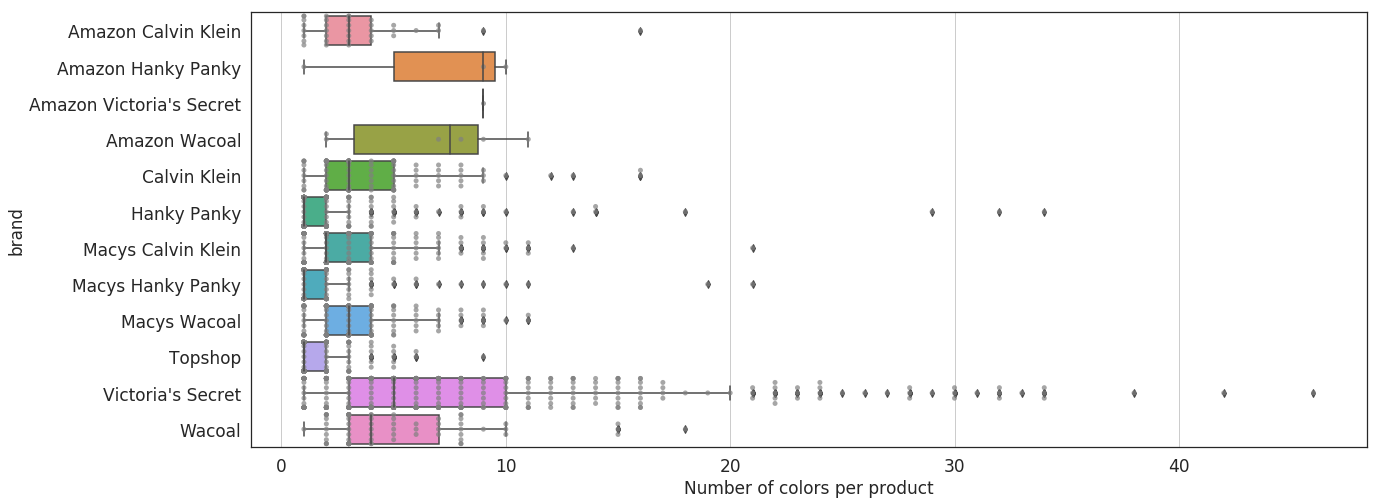

In [ ]:
colors_df = pd.DataFrame()    
for name, group in brands_info.groupby('brand'):
    colors = group.groupby(['product_name']).color.nunique()
    colors_df = colors_df.append(pd.DataFrame({'color_num': colors, 'brand': name}))

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,8))
ax = sns.boxplot(x='color_num', y='brand', data=colors_df, ax=axes, medianprops={"zorder":3})
ax = sns.swarmplot(x="color_num", y="brand", data=colors_df, color='grey', alpha=0.7)
ax.xaxis.grid(True)
ax.set_xlabel('Number of colors per product', fontsize=17);
ax.tick_params(axis='both', which='major', labelsize=17);


In [ ]:
colors_df.groupby('brand').agg(['median', 'mean', 'count']).transpose()

Lets have a closer look on the products that have more than 35 colors.
(Amazon Hanky Panky has 6 colors as mean but there are only 3 unique products, two with 10 and 9 colors and one with 1 colors.)

Some models of bras and panties have an extraordinary number of colors :). 'the player racerback sport bra' has the most colors , followed by 'seamless hiphugger panty' from Victoria's Secret!

In [ ]:
display(colors_df[colors_df['color_num']>=35])
del colors_df

color_num              brand
product_name                                                                                 
seamless hiphugger panty                                         42         Victoria's Secret
victoria sport lightweight by victoria sport bra                 38         Victoria's Secret
victoria sport the player racerback sport bra by victoria sport  46         Victoria's Secret

In [ ]:
#brands_info[brands_info['product_name'] == 'victoria sport the player racerback sport bra by victoria sport'].color.unique()

**Question 9**: What color dominates?

So, seems that the most products have black color (what is also expected actually) and the second most color is mostly white or bare except for some brands. And Macys Hanky Panky is red ;). 

I wonder what color is 'wild aster' offered by Wacoal.

In [ ]:
colors_first = brands_info.groupby(['brand','color'])['color'].agg({'count_fir':'count'})
df_count_first = colors_first.groupby(level=0).agg('idxmax')
df_count_first = colors_first.loc[df_count_first['count_fir']].reset_index()

data_mod = brands_info[~brands_info['color'].isin(df_count_first.color.unique())]
colors_second = data_mod.groupby(['brand','color'])['color'].agg({'count_sec':'count'})
df_count_second = colors_second.groupby(level=0).agg('idxmax')
df_count_second = colors_second.loc[df_count_second['count_sec']].reset_index()

df = df_count_first.merge(df_count_second, on='brand')
df.columns = ['brand', '1st color', 'count 1st color', '2nd color', 'count 2nd color']
display(df)

for x in [df_count_first, df_count_second, df, data_mod, colors_first]:
    del x

brand       ...       count 2nd color
0   Amazon Calvin Klein            ...        9             
1   Amazon Hanky Panky             ...        2             
2   Amazon Victoria's Secret       ...        1             
3   Amazon Wacoal                  ...        2             
4   Calvin Klein                   ...        35            
5   Hanky Panky                    ...        35            
6   Macys Calvin Klein             ...        42            
7   Macys Hanky Panky              ...        19            
8   Macys Wacoal                   ...        30            
9   Topshop                        ...        23            
10  Victoria's Secret              ...        86            
11  Wacoal                         ...        19            

[12 rows x 5 columns]

Wild auster color:
<img src='https://images-na.ssl-images-amazon.com/images/I/91Cai0vSt-L._SL1500_.jpg' style='width: 200px;'>
    


# 2 Prices are so high nowadays ...
To make it simplier we will have several main categories and everything else we will simmary as 'Other'. I know, after such hard work categorizing data we will still need to unite some categories.

In [ ]:
main_categories = ['bralettes','activewear','bras','panties','bodys','pack','babydoll', 'swimsuits', 'sleepwear']
brands_info['product_category'] = brands_info['product_category_gen']
brands_info['category'] = brands_info['product_category_gen']
brands_info.loc[~brands_info['category'].isin(main_categories), 'category'] = 'Other'
del brands_info['product_category_gen']

## 2.1 MRP - Maximum Retailer Price

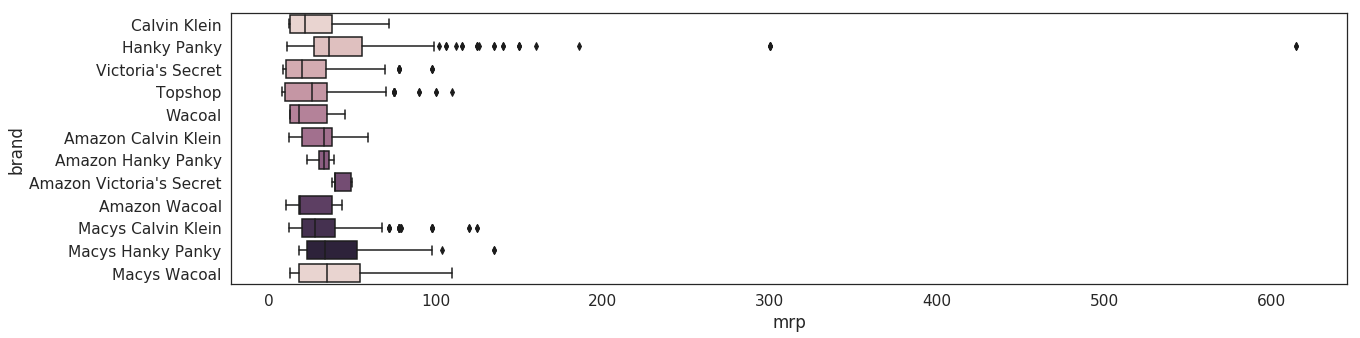

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,5))
ax = sns.boxplot(x='mrp', y= 'brand', data = brands_info, palette = purple, order = brands_name) 

**Question 11**: Hanky Panky has really several outliers. And some of them cost over 600 USD!!! What are those products?

In [ ]:
brands_info[(brands_info['mrp']>300)&(brands_info['brand']=='Hanky Panky')].product_name.unique()

array(['30 pack original rise thongs in lucite jar',
       '30 pack low rise thongs in lucite jar'], dtype=object)

Want a 30 pack thongs of different colors for 600 USD? ;)

## MRP Distribution

In [ ]:
def general_plot(money = 'mrp'):
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,5))
    ax = sns.boxplot(x=money, y= 'brand', data = brands_info[brands_info[money]<150], palette = purple, order = brands_name) 
    _ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)


    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,4))
    ax.xaxis.grid(True)
    ax = sns.barplot(y=money, x = 'brand', data = brands_info, palette = light_purple[1:], ax = axes[0], order = brands_name)
    ax.yaxis.grid(True)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=13)
    ax = sns.barplot(y=money, x = 'brand', data = brands_info, palette = light_purple[1:], estimator=np.median, ax = axes[1], order = brands_name)
    ax.yaxis.grid(True)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=13)

* Macy's Calvin Klein, Macy's Hanky Panky and Hanky Panky have some product with the mrp > 120. It needs a look.
* It seems that Calvin Klein is a bit more expensive than Victoria's Secret.
* Wacoal seems to be the cheapest brand. But Macy's Wacoal is by far more expensive than OW.
* Amazon Calvin Klein is more expensive than OW Calvin Klein. (Also Macy's is a but more expensive)

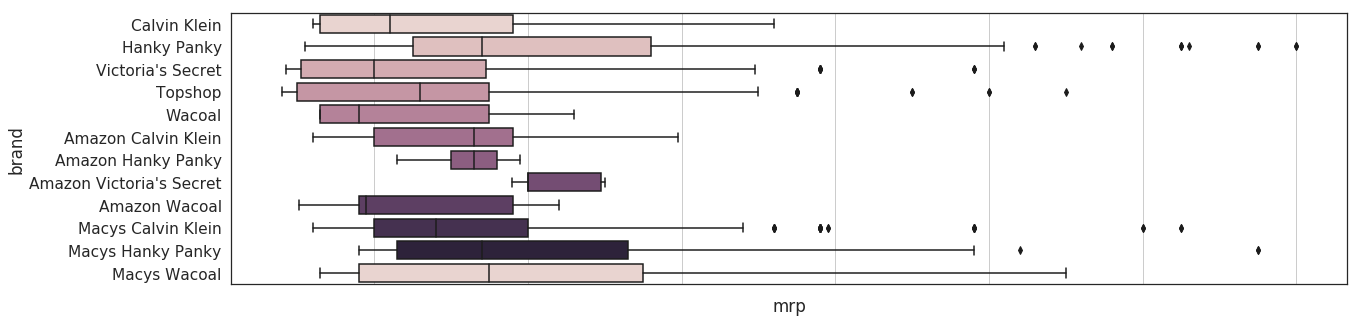

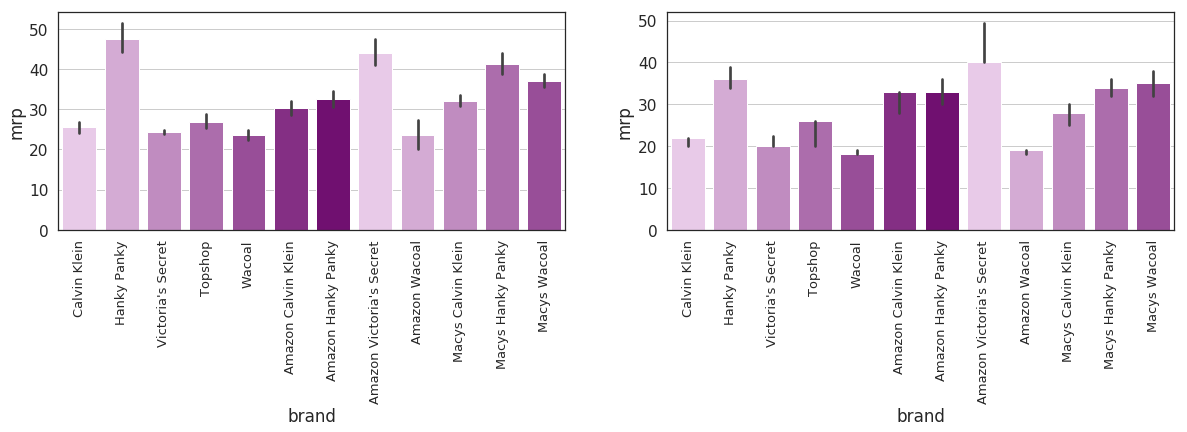

In [ ]:
general_plot()

## Price Distribution
* It seems that Calvin Klein is a bit more expensive than Victoria's Secret.
* Wacoal and Victoria's Secret seem to be the cheapest brand. But Macy's Wacoal is by far more expensive than OW.
* Discounted Amazon Calvin Klein and Calvin Klein have the same prices. 

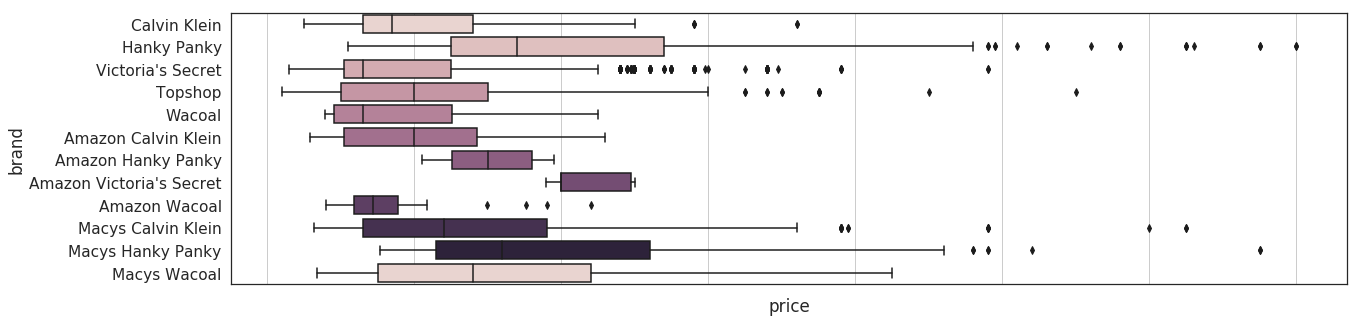

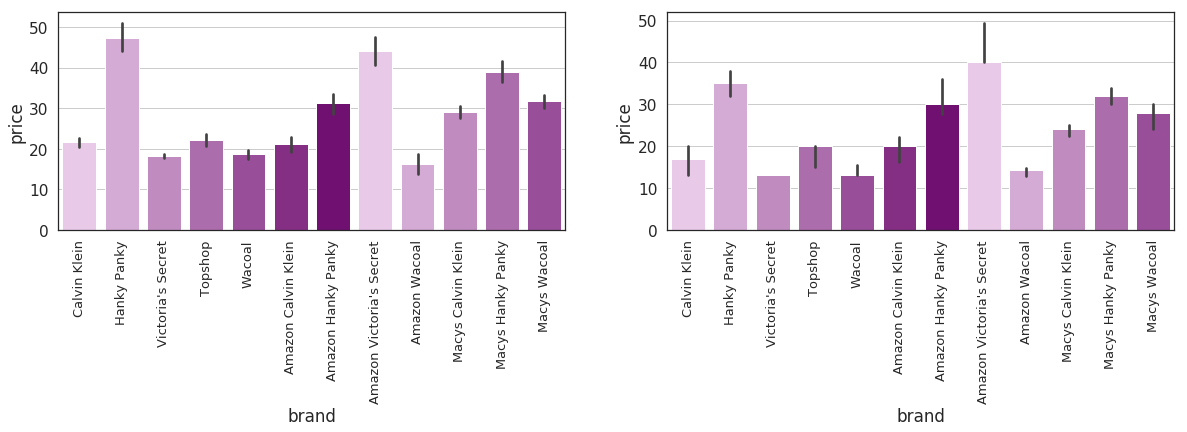

In [ ]:
general_plot(money = 'price')

**Question 11**: What are all those products with the mrp > 120?

Those categories are definite the most of the expensive ones :)

In [ ]:
brands_info[(brands_info['mrp']>120) & (brands_info['category']!='pack')].product_category.unique()

array(['robe', 'babydoll', 'bodys'], dtype=object)

Looks good, doesnt it?

In [ ]:
brands_info[brands_info['product_name']=='alexandra lace robe']

Unnamed: 0    mrp   ...           brand category
1073  1073        140.0   ...     Hanky Panky  Other  

[1 rows x 11 columns]

In [ ]:
from IPython.display import HTML, display
html = "<table><tr><td>Hanky Panky: sophia lace bodysuit<img src='http://www.hankypankyltd.netdna-cdn.com/media/catalog/product/cache/1/image/db978388cfd007780066eaab38556cef/7/9/798504_black_4.jpg' style='width: 800px;'></td><td>Hanky Panky: short european flannel robe<img src='http://www.hankypankyltd.netdna-cdn.com/media/catalog/product/cache/1/image/db978388cfd007780066eaab38556cef/2/v/2vr114_1.jpg' style='width: 800px;'></td><td>Hanky Panky: alexandra lace robe<img src='http://www.hankypankyltd.netdna-cdn.com/media/catalog/product/cache/1/image/db978388cfd007780066eaab38556cef/9/1/91r111_black_1.jpg' style='width: 900px;'></td><td>Hanky Panky: wink plaything<img src='http://www.hankypankyltd.netdna-cdn.com/media/catalog/product/cache/1/image/db978388cfd007780066eaab38556cef/4/t/4t8504_black_1.jpg' style='width: 900px;'></td><td>Hanky Panky: victoria chemise with g string<img src='http://www.hankypankyltd.netdna-cdn.com/media/catalog/product/cache/1/image/db978388cfd007780066eaab38556cef/9/4/945901_2.jpg' style='width: 900px;'></td><td>Hanky Panky: heather jersey kimono robe<img src='http://www.hankypankyltd.netdna-cdn.com/media/catalog/product/cache/1/image/db978388cfd007780066eaab38556cef/6/8/68r222_wine_1.jpg' style='width: 900px;'></td><td>Macy's Calvin Klein<img src='https://cdna.lystit.com/200/250/tr/photos/saksfifthavenue/0400093782409-black-6d6c9f31-.jpeg' style='width: 900px;'></td></tr></table>"
display(HTML(html))

# The most expensive items

**Question 11**: What is the most expensive item (by mrp) in each brand?

In [ ]:
df = pd.DataFrame(brands_info.groupby('brand').mrp.max()).reset_index()
df2 = pd.DataFrame(brands_info.groupby('brand').price.max()).reset_index()
df = df.merge(df2, on='brand')
display(df)

brand     mrp   price
0   Amazon Calvin Klein       59.50   46.00 
1   Amazon Hanky Panky        39.00   39.00 
2   Amazon Victoria's Secret  49.99   49.99 
3   Amazon Wacoal             44.00   44.00 
4   Calvin Klein              72.00   72.00 
5   Hanky Panky               615.00  615.00
6   Macys Calvin Klein        125.00  125.00
7   Macys Hanky Panky         135.00  135.00
8   Macys Wacoal              110.00  85.00 
9   Topshop                   110.00  110.00
10  Victoria's Secret         98.00   98.00 
11  Wacoal                    46.00   45.00

In [ ]:
expensive_items_mrp = pd.DataFrame()
expensive_items_price = pd.DataFrame()

for ind, row in df.iterrows():
    df_temp = brands_info[(brands_info['brand']==row['brand'])&(brands_info['mrp']==row['mrp'])]
    names = df_temp.product_name.unique()
    expensive_items_mrp = expensive_items_mrp.append(df_temp.iloc[0])

    df_temp = brands_info[(brands_info['brand']==row['brand'])&(brands_info['price']==row['price'])]
    listings = list(set(df_temp.product_name) - set(names))
    if len(listings)!=0:
        df_temp = df_temp[(df_temp['product_name'].isin(listings))]
        expensive_items_price = expensive_items_price.append(df_temp.iloc[0])
#display(expensive_items_mrp.head(5))

So, the most expensive item in our datatset is from Hanky Panky and that is 30 pairs of thongs!

In [ ]:

html = "<table><tr><td>Calvin Klein<img src='https://cdnd.lystit.com/1040/1300/n/photos/shopbop/CKLEN4233210437-Black-04ad40dc-.jpeg' style='width: 900px;'></td><td>Hanky Panky<img src='http://www.hankypankyltd.netdna-cdn.com/media/catalog/product/cache/1/image/db978388cfd007780066eaab38556cef/4/8/48pk30_emul_1_1.jpg' style='width: 800px;'></td><td>Victorias Secret<img src='https://dm.victoriassecret.com/p/760x1013/tif/b4/4f/b44f5a12e28c4b8c9dcab27faae01013/V493406_OF_F.jpg' style='width: 900px;'></td><td>Topshop<img src='http://media.topshop.com/wcsstore/TopShopDE/images/catalog/TS43E04LLAC_Zoom_F_1.jpg' style='width: 900px;'></td><td>Wacoal<img src='https://a248.e.akamai.net/f/248/9086/10h/origin-d5.scene7.com/is/image/WacoalAmerica/953237_004?qlt=85,1&op_sharpen=1&resMode=bilin&op_usm=1,1,9,0&rect=0,0,261,344&scl=5.816860465116279&id=VFprq1' style='width: 900px;'></td></tr></table>"
display(HTML(html))
html = "<table><tr><td>Amazon Calvin Klein<img src='https://images-na.ssl-images-amazon.com/images/I/61wmAanrDzL._UL1500_.jpg' style='width: 900px;'></td><td>Amazon Victorias Secret<img src='https://images-na.ssl-images-amazon.com/images/I/71CxBauOwPL._UL1500_.jpg' style='width: 900px;'></td><td>Amazon Hanky Panky<img src='https://images-na.ssl-images-amazon.com/images/I/71gd1OukSaL._UL1500_.jpg' style='width: 900px;'></td><td>Amazon Wacoal<img src='https://images-na.ssl-images-amazon.com/images/I/81uAK8Lvx8L._UL1500_.jpg' style='width: 900px;'></td><td>Macys Calvin Klein<img src='https://cdna.lystit.com/200/250/tr/photos/saksfifthavenue/0400093782409-black-6d6c9f31-.jpeg' style='width: 900px;'></td><td>Macys Hanky Panky<img src='https://image.shopittome.com/apparel_images/fb/hanky-panky-hanky-panky-eyelash-lace-bodysuit-4t8504-abv6af8ff20_zoom.jpg' style='width: 900px;'></td><td>Macys Wacoal<img src='https://slimages.macysassets.com/is/image/MCY/products/0/optimized/3831480_fpx.tif?op_sharpen=1&wid=400&hei=489&fit=fit,1&$filterlrg$' style='width: 900px;'></td></tr></table>"
display(HTML(html))

**Question 12**: What is the most expensive discounted item (by price) in each brand?

In [ ]:
#display(expensive_items_price)

In [ ]:
html = "<table><tr><td>Amazon Calvin Klein<img src='https://images-na.ssl-images-amazon.com/images/I/81LEl1kn5oL._UL1500_.jpg' style='width: 200px;'></td><td>Macys Wacoal<img src='https://slimages.macysassets.com/is/image/MCY/products/5/optimized/3640215_fpx.tif??op_sharpen=1&fit=fit,1&$filterlrg$&wid=1200&hei=1467' style='width: 200px;'></td><td>Wacoal<img src='https://images.prod.meredith.com/product/96a181a21f45ac2c2183d2076f789d9d/53fc48ce1c2d384f512eaa489f2011980c2dc667471d96e0ad01570626b111b8/l/womens-b-temptd-by-wacoal-b-sultry-chemise' style='width: 200px;'></td></tr></table>"
display(HTML(html))

So, back to the reality.

## 2.1.1 What are the MRP distributions?

In [ ]:
def create_plots(cols, swarm = False, inner = None, money = 'mrp'):
    df = brands_info[brands_info[money]<=100]
    df2 = df[df['brand'].isin(cols)]
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,5))
    ax = sns.violinplot(y=money, x='brand', data=df2, split=True,inner=inner, ax = axes, palette = light_purple)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize=13)
    if swarm:
        ax = sns.swarmplot(x="brand", y=money, data=df2, color="black", alpha=.5, ax = axes)
    ax.yaxis.grid(True)
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,6))
    ax = sns.boxplot(y=money,hue='category',x = 'brand',data = df2, palette=sns.color_palette("husl", 10))
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize=13)
    ax.yaxis.grid(True)
    _ = ax.set_ylabel(money)    

**Question 13**: What products cause distributions and what are the reasons for the same brands have different mrp  ranges on different sites.

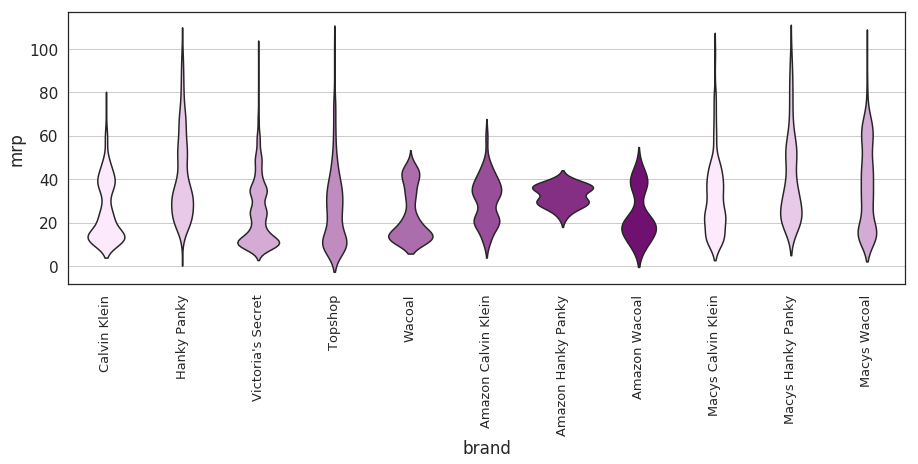

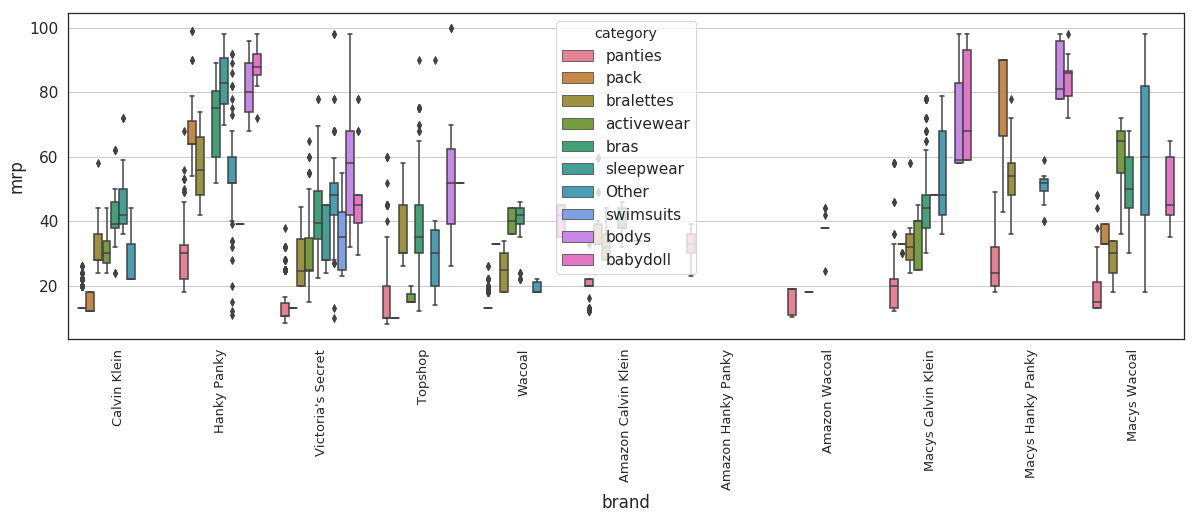

In [ ]:
create_plots(['Calvin Klein', "Victoria's Secret", 'Topshop', 'Wacoal', 'Hanky Panky', 'Amazon Calvin Klein', 'Macys Calvin Klein','Amazon Hanky Panky', 'Macys Hanky Panky','Amazon Wacoal', 'Macys Wacoal'])

### Oficial Websites

* Most of the Victoria's Secret's products have the price around 12 dollars. That are the panties. The next major products have the price of around 38 dollars. And that are the bras and bodys and other products.<br>
* Calvin Klein's most products have the price around 13 dollars. <br>
* Most of Topshop products are around 12 dollars and Wacoal's products around 13 dollars.
* Hanky Panky seems to be the most expensive brand

* The peaks around 13 are panties and peaks upwards are bras, bralettes etc.

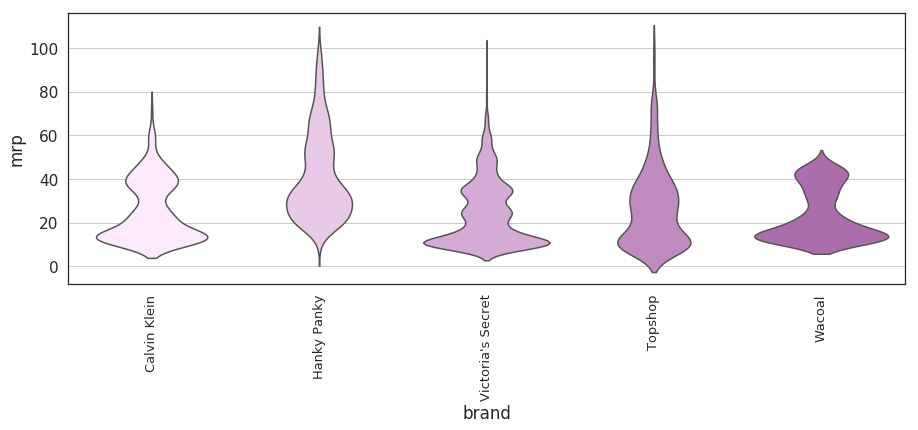

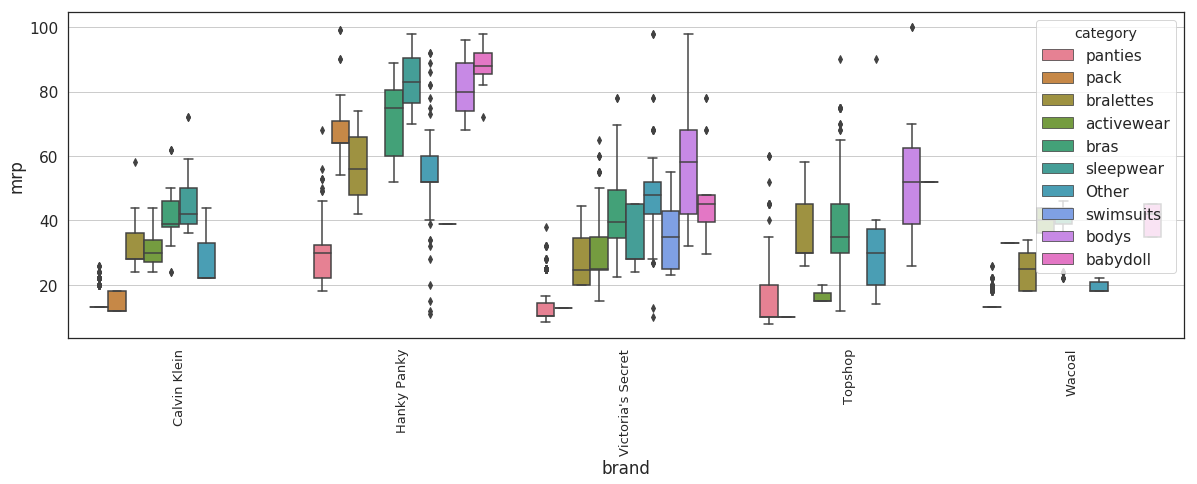

In [ ]:
create_plots(['Calvin Klein', "Victoria's Secret", 'Topshop', 'Wacoal', 'Hanky Panky'])

### Calvin Klein

**Question 14:** Why is Amazon Calvin Klein more expensive than Calvin Klein Website. (Also Macy's is a bit more expensive)?

* Calvin Klein official website sells more less expensive panties (around 13 USD) than Amazon Calvin Klein (around 20 USD)
* Expensive packs (2-,3-,5- sets) are sold mainly on Amazon.
* Macy's sells expensive bodys and babydolls.

* As we know from Question 4 around 55% of products of Calvin Klein are those inexpensive panties. That is the reason why on average Calvin Klein is less expensive than Amazon. But think about packs that Amazon offers. MRP for a panty can be less in a 5-pack but you will not be able to chose the colors that you want if you are super picky :P


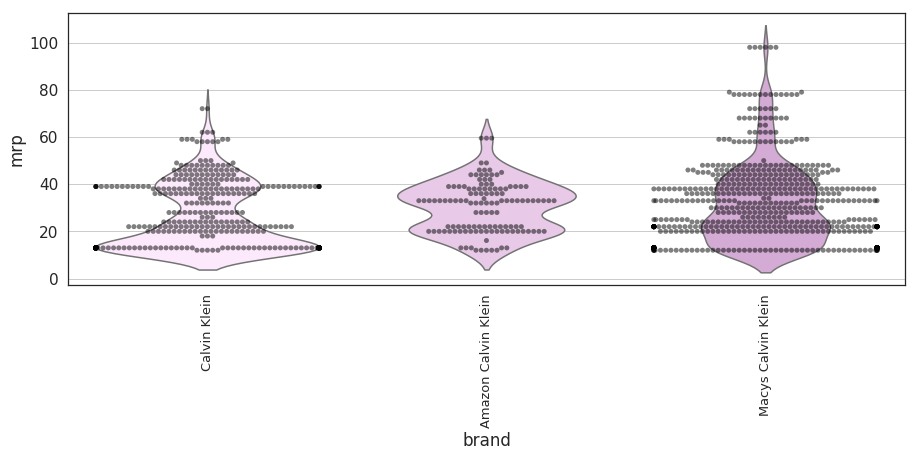

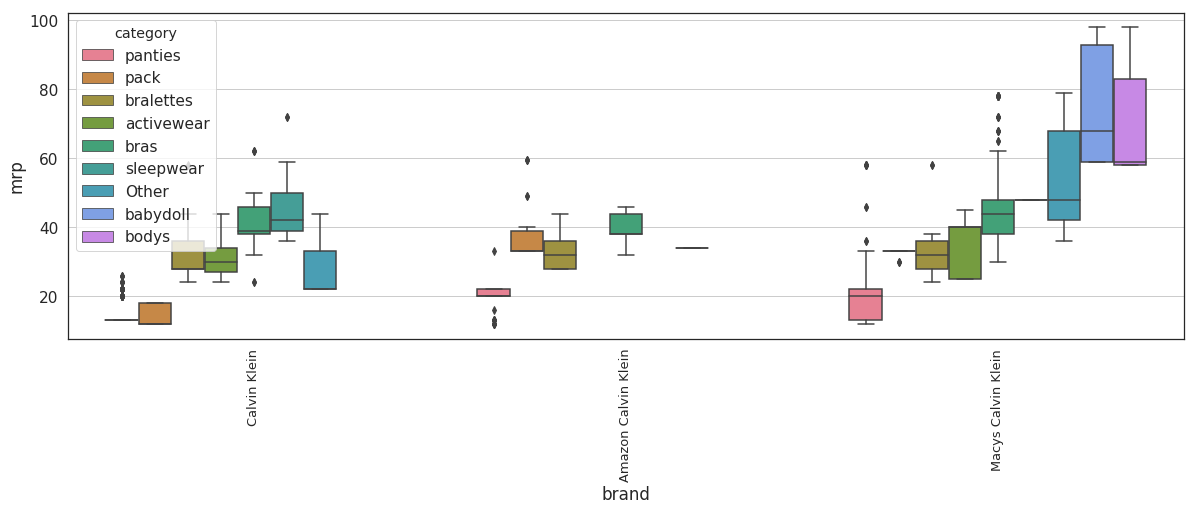

In [ ]:
create_plots(['Calvin Klein', 'Amazon Calvin Klein', 'Macys Calvin Klein'], swarm = True)

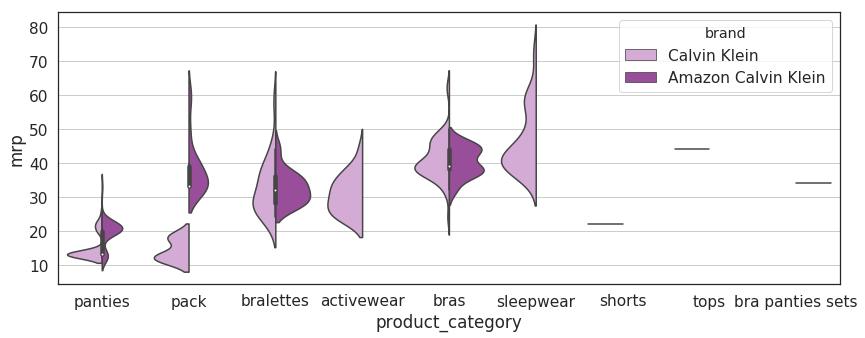

In [ ]:
df = brands_info[(brands_info['brand'].isin(['Amazon Calvin Klein','Calvin Klein']))]
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(14,5))
ax = sns.violinplot(y="mrp", hue ='brand', x = 'product_category', split=True, data=df, ax = axes, palette = [light_purple[2], light_purple[5]])
ax.yaxis.grid(True)

So, in fact if you buy packs on Amazon you will pay less for each panty (around 11USD or discounted 8 USD) than on official website.

In [ ]:
def find_price_per_panty(brand):
    
    pack_panties = brands_info[(brands_info['brand']==brand)&(brands_info['category']=='pack')]
    pack_panties = pack_panties[~pack_panties['product_name'].str.contains(manipul_regex(['bra', 'bralette']))]
    def find_digit(x):
        for s in x.split():
            if s.isdigit():
                return int(s)
    pack_panties['panties_num'] = pack_panties['product_name'].apply(lambda x: find_digit(x))
    mrp = (pack_panties['mrp']/pack_panties['panties_num'])
    price = (pack_panties['price']/pack_panties['panties_num'])
    return [mrp,price]

In [ ]:
hankypanky_mrp, hankypanky_price = find_price_per_panty('Hanky Panky')
macysck_mrp, macysck_price = find_price_per_panty('Macys Calvin Klein')
amazonck_mrp, amazonck_price = find_price_per_panty('Amazon Calvin Klein')


In [ ]:
packs_price = pd.DataFrame({'brand': 'Amazon Calvin Klein', 'mrp': amazonck_mrp})
packs_price = packs_price.append(pd.DataFrame({'brand': 'Macys Calvin Klein', 'mrp': macysck_mrp})) 
packs_price = packs_price.append(pd.DataFrame({'brand': 'Hanky Panky', 'mrp': hankypanky_mrp})) 

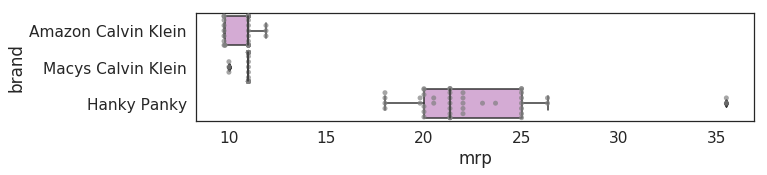

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,2))
ax = sns.boxplot(y='brand', x='mrp',data = packs_price, ax = axes, medianprops={"zorder":3},
                palette = [light_purple[2],light_purple[6]])
ax = sns.swarmplot(y='brand', x='mrp',data = packs_price, color = 'grey',alpha=0.7)

Text(0.5,0,'price per panty from a pack')

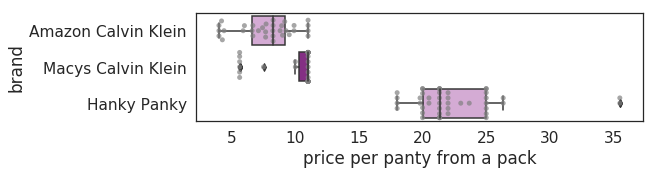

In [ ]:
packs_price = pd.DataFrame({'brand': 'Amazon Calvin Klein', 'price': amazonck_price})
packs_price = packs_price.append(pd.DataFrame({'brand': 'Macys Calvin Klein', 'price': macysck_price})) 
packs_price = packs_price.append(pd.DataFrame({'brand': 'Hanky Panky', 'price': hankypanky_price})) 

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,2))
ax = sns.boxplot(y='brand', x='price',data = packs_price, ax = axes, medianprops={"zorder":3},
                 palette = [light_purple[2],light_purple[6]])
ax = sns.swarmplot(y='brand', x='price',data = packs_price, color = 'grey',alpha=0.7)
ax.set_xlabel('price per panty from a pack')

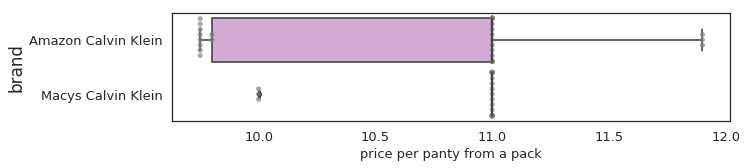

In [ ]:
packs_price = pd.DataFrame({'brand': 'Amazon Calvin Klein', 'mrp': amazonck_mrp})
packs_price = packs_price.append(pd.DataFrame({'brand': 'Macys Calvin Klein', 'mrp': macysck_mrp})) 

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,2))
ax = sns.boxplot(y='brand', x='mrp',data = packs_price, ax = axes, medianprops={"zorder":3},
                palette = [light_purple[2],light_purple[6]])
ax = sns.swarmplot(y='brand', x='mrp',data = packs_price, color = 'grey',alpha=0.7)
ax.set_xlabel('price per panty from a pack',fontsize=13)
_= ax.tick_params(axis='both', which='major', labelsize=13)

### Wacoal

* Amazon sells a bit more expensive panties of Wacoal than on the official website, whereas on Macys there is a nice gradient of all prices.
* The expensive products in Other category are mainly shapers that are not sold on other sites.

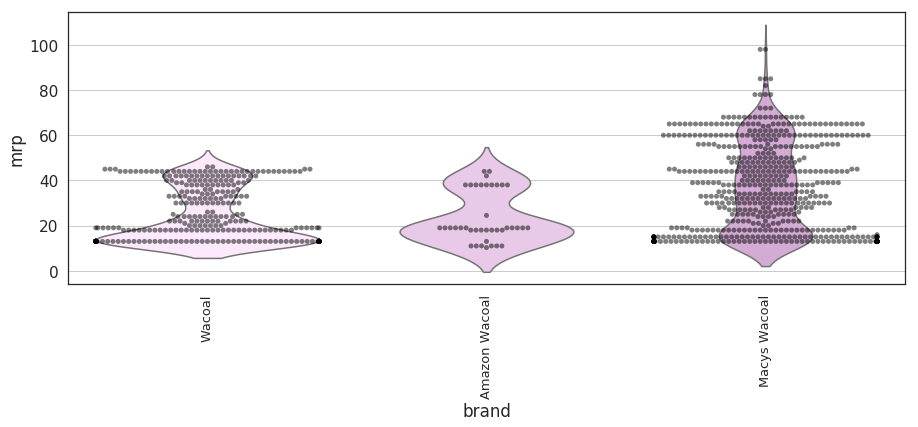

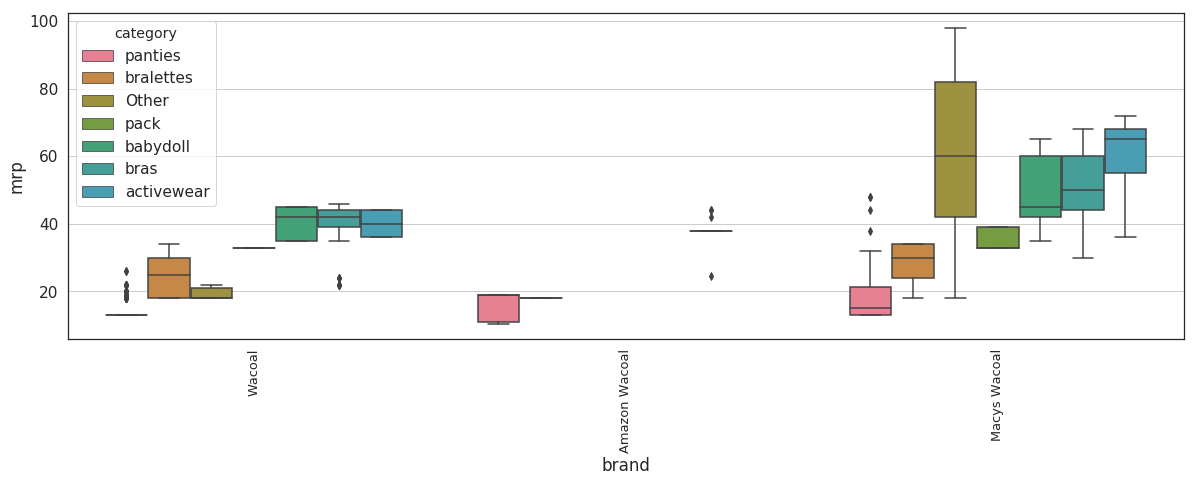

In [ ]:
create_plots(['Wacoal', 'Amazon Wacoal', 'Macys Wacoal'], swarm = True)

## Hanky Panky
* Official webiste of HP and Macy sells almost the same price range of products, whereas Amazon goes for panties that are also a bit more expensive.

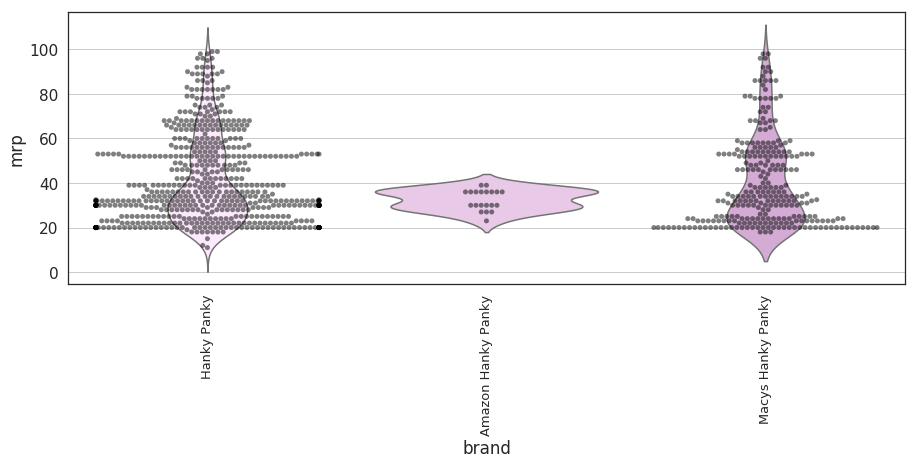

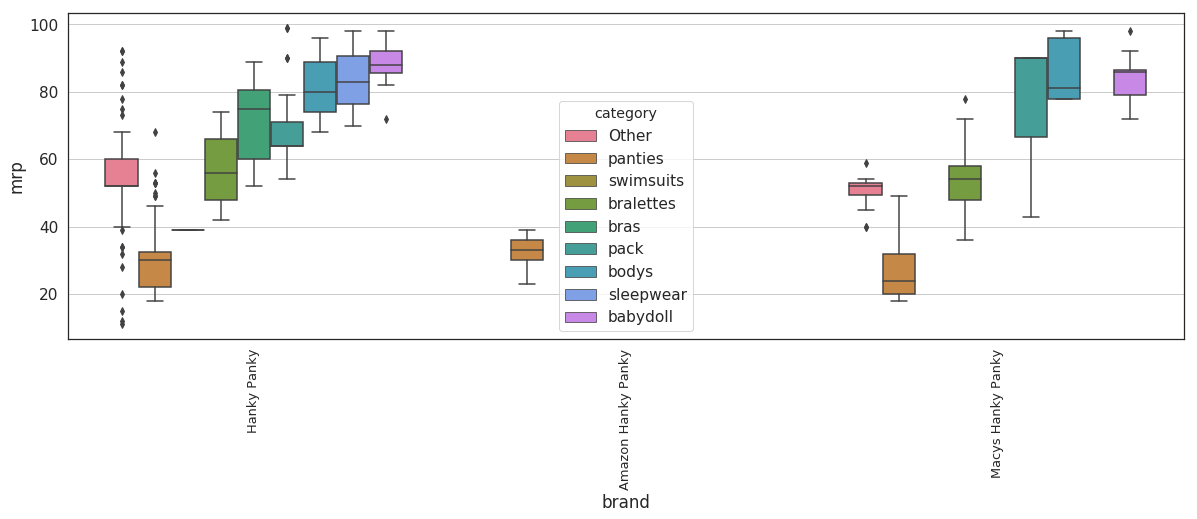

In [ ]:
create_plots(['Hanky Panky', 'Amazon Hanky Panky', 'Macys Hanky Panky'],swarm = True)

In [ ]:
def create_plots(cols, swarm = False, inner = None, money = 'mrp'):
    df = brands_info[brands_info[money]<=100]
    df2 = df[df['brand'].isin(cols)]
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,5))
    ax = sns.violinplot(x=money, y='brand', data=df2, split=True,inner=inner, ax = axes, palette = [light_purple[0], light_purple[2], light_purple[5]])
    if swarm:
        ax = sns.swarmplot(x="brand", y=money, data=df2, color="black", alpha=.5, ax = axes)
    ax.yaxis.grid(True)
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,5))
    ax = sns.boxplot(y=money,hue='category',x = 'brand',data = df2, palette=sns.color_palette("husl", 9))
    ax.yaxis.grid(True)
    _ = ax.set_ylabel(money)

## Victoria's Secret
As we know Amazon sells only one kind of bra of Victoria's Secret. However, we have still a price distribution, meaning that the prices are different for colors or sizes or both.

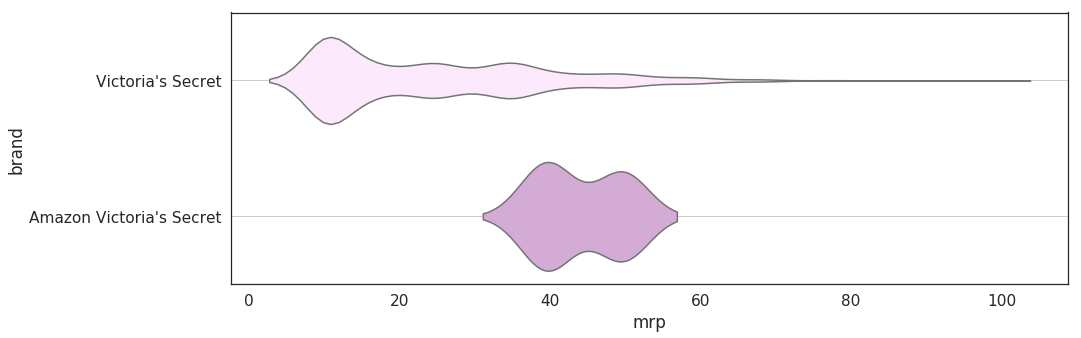

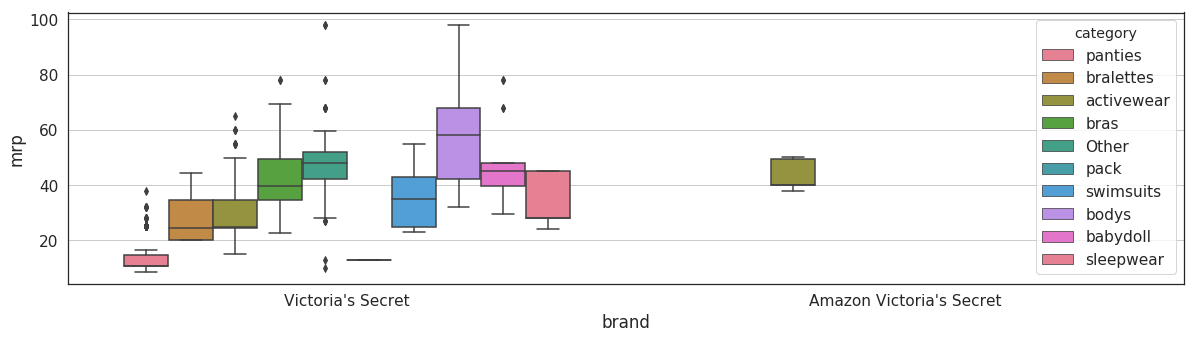

In [ ]:
create_plots(["Victoria's Secret", "Amazon Victoria's Secret"],swarm = False)

## 3.2 What is more expensive: bras from Victoria's Secret or Calvin Klein?

In [ ]:
def category_plots(category, data, y= 'brand',xtitle = 'mrp',money = 'mrp', swarm = True, 
                   figsize1=(15,6), figsize2=(15,6), figsize3=(20,4),
                  filename = None):
    df = data[data['category'].isin(category)]
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=figsize1)
    #ax = sns.boxplot(x=money, hue ='brand', y = 'category',  data=df, ax = axes)
    ax = sns.boxplot(x=money, y= y, data=df, ax=axes, medianprops={"zorder":3})
    if swarm:
        ax = sns.swarmplot(y = y, x=money, data=df, ax = axes, color = 'grey', alpha=0.7)
    ax.xaxis.grid(True)
    ax.set(xlabel=xtitle)
    
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=figsize2)
    ax = sns.violinplot(y=money, x=y, data=df, ax=axes, cut = 0)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.yaxis.grid(True)
    ax.set(ylabel=xtitle)
    _ = ax.set_title(", ".join(category))
    if filename!= None:
        fig.savefig(filename + '1.png')
    barplots(money,df, figsize3, x=y, xtitle = xtitle)
    


def barplots(money, df, figsize3, xtitle = 'mrp', x = 'brand', hue = None, palette = light_purple[1:]):
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=figsize3)
    ax = sns.barplot(y=money, x = x, hue = hue, data = df, palette = palette, ax = axes[0])
    ax.set(ylabel='mean(' + xtitle + ')')
    ax.yaxis.grid(True)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax = sns.barplot(y=money, x = x, hue = hue, data = df, palette = palette, estimator=np.median, ax = axes[1])
    ax.set(ylabel='median(' + xtitle + ')')
    display(df.groupby('brand')[money].agg({'median'}).transpose())
    display(df.groupby('brand')[money].agg({'mean'}).transpose())

    ax.yaxis.grid(True)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


**Question 14**: What is more expensive: bras from Victoria's Secret or Calvin Klein?
* Hanky Panky has the most expensive bras but also there are not so many of them (Question 4)
* Victoria's Secret has lots of bras that cost less than the majority of Calvin's Klein bras. However, VC has also bras of higher price.
* Macys Wacoal bras are more expensive than on the another representatives of Wacoal as they sell more expensive bras, whereas other (amazon and macys) sell only less expensive bras

In [ ]:
for name, group in brands_info.groupby('brand'):
    print(name)
    print((group[(group['category']=='bras')].mrp<40).sum())

Amazon Calvin Klein
13
Amazon Hanky Panky
0
Amazon Victoria's Secret
0
Amazon Wacoal
10
Calvin Klein
50
Hanky Panky
0
Macys Calvin Klein
51
Macys Hanky Panky
0
Macys Wacoal
36
Topshop
88
Victoria's Secret
274
Wacoal
24


brand   Amazon Calvin Klein  Amazon Wacoal   ...    Victoria's Secret  Wacoal
median  38.0                 38.0            ...    39.5               42.0  

[1 rows x 9 columns]

brand  Amazon Calvin Klein    ...         Wacoal
mean   40.1984                ...      40.037037

[1 rows x 9 columns]

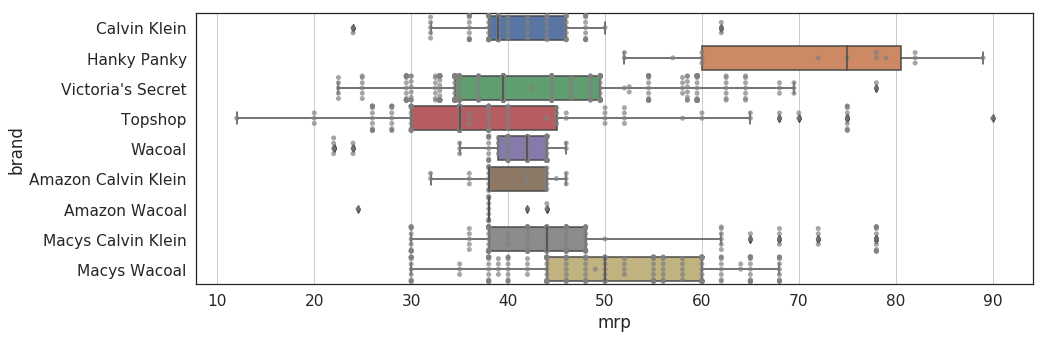

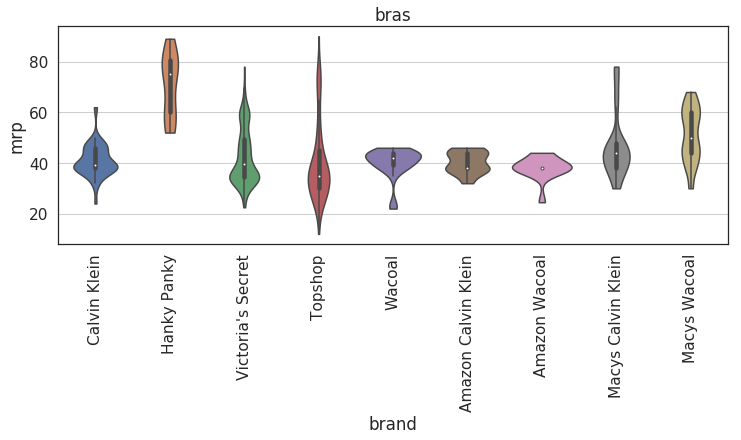

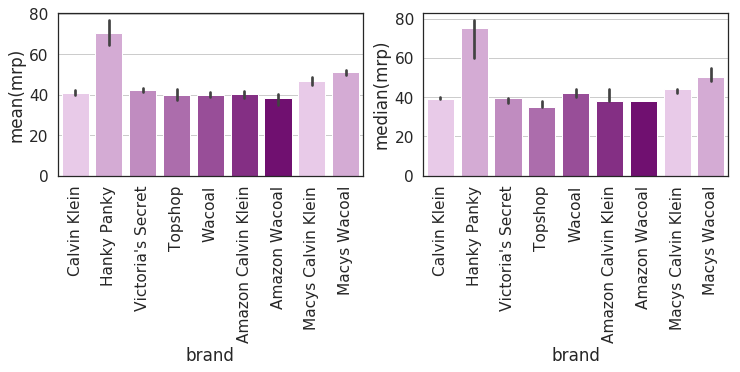

In [ ]:
category_plots(['bras'], brands_info,
               figsize1=(15,5), figsize2=(12,4), figsize3=(12,3), filename = 'bras_mrp')

**Question 14**: Panties of which brand are the most expensive?
* Amazon Hanky Panky has the most expensive panties (20 products). In general, Hanky Panky has more expensive panties.
* The majority of Victoria's Secret panties tend to be a bit cheaper (do not forget Calvin Klein has an offer '3 Panties for 33USD', however, no such offer was specified for Victoria's Secret, although I know such offers exist on the website). 
* Calvin Klein has around 190 (76% of Clavin Klein's panties) with a mrp of 13 USD.
* Majority of Wacoals and Calvin Klein panties have the same price.
* Although Topshow has a wide distribution of mrp, it has quite a lot very cheap panties.
* Amazon's Calvin Klein most panties are more expensive than of the OW.
* Amazon Wacoal has bimodal distribution. In fact, it seels only 2 models of panties. Model 'ciao bella tanga panty' has the price of 19 USD, whereas model 'kiss thong panty' around 11 USD.

brand   Amazon Calvin Klein   ...    Wacoal
median  20.0                  ...    13.0  

[1 rows x 11 columns]

brand  Amazon Calvin Klein    ...         Wacoal
mean   19.2822                ...      14.389423

[1 rows x 11 columns]

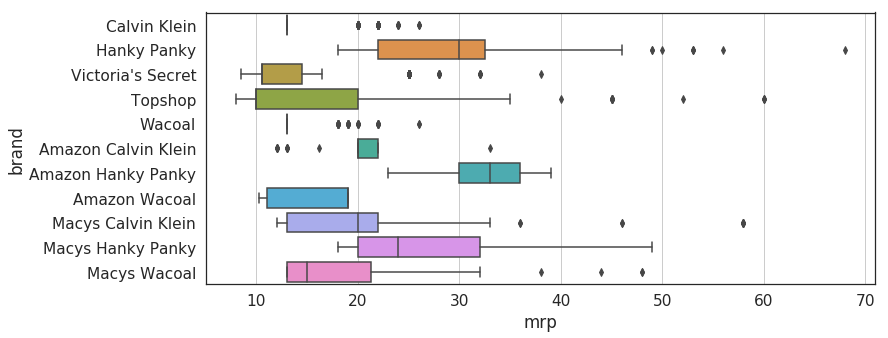

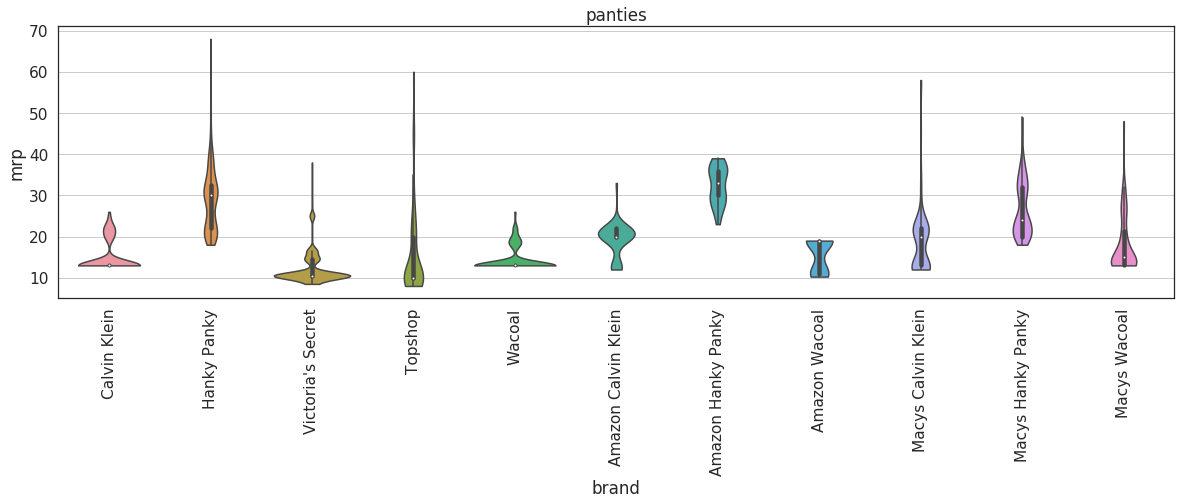

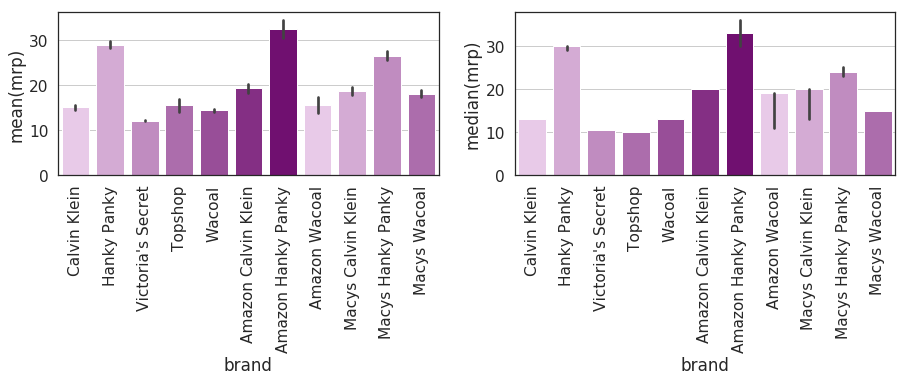

In [ ]:
category_plots(['panties'], brands_info, swarm = False, figsize1=(12,5),figsize2=(20,5), figsize3=(15,3))

**Question 15**: Bralettes of which brand are the most expensive?
* Bralettes of Hanky Panky are the most expensive ones.
* Victoria's Secret is less expensive than CV.
* Wacoal and Victoria's Secret have the cheapest bralettes


brand   Amazon Calvin Klein  Amazon Wacoal   ...    Victoria's Secret  Wacoal
median  32.0                 18.0            ...    24.5               25.0  

[1 rows x 10 columns]

brand  Amazon Calvin Klein    ...         Wacoal
mean   32.571429              ...      25.571429

[1 rows x 10 columns]

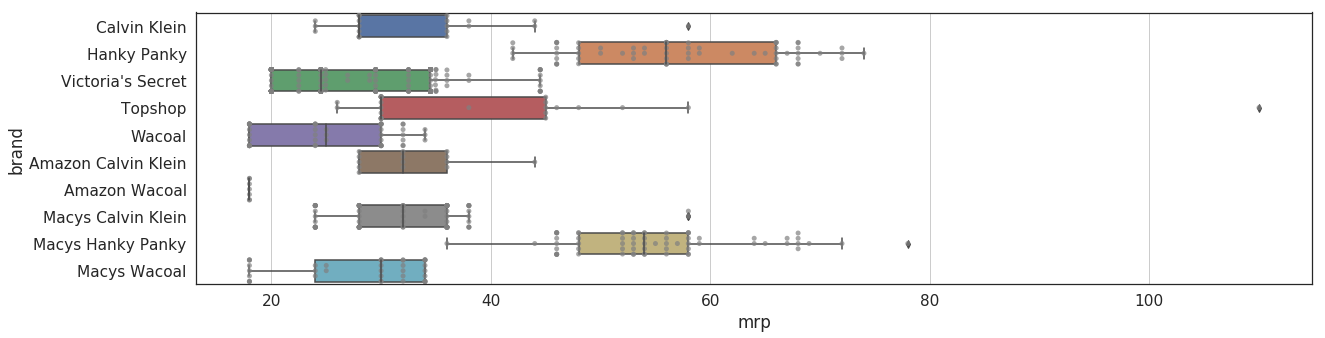

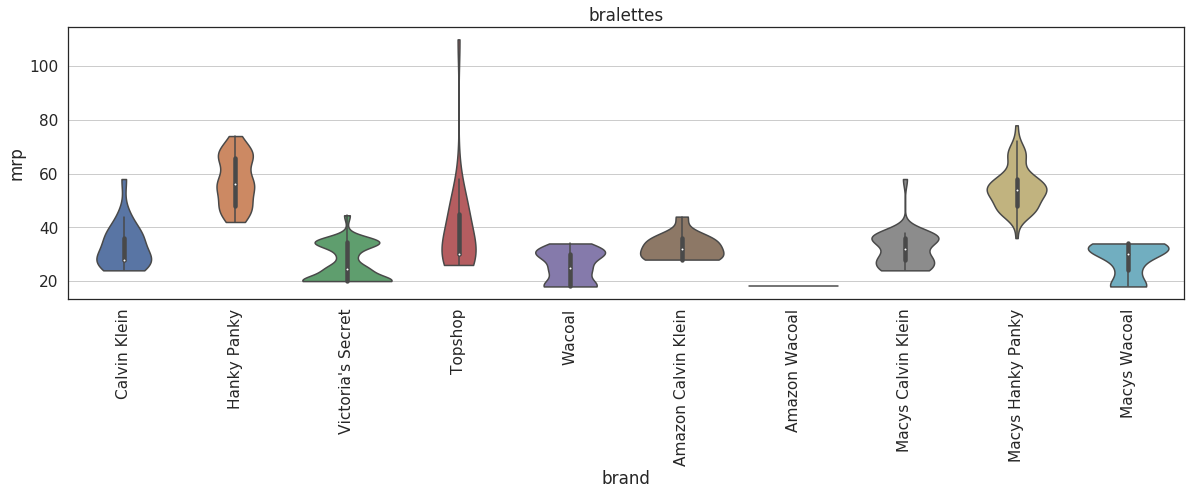

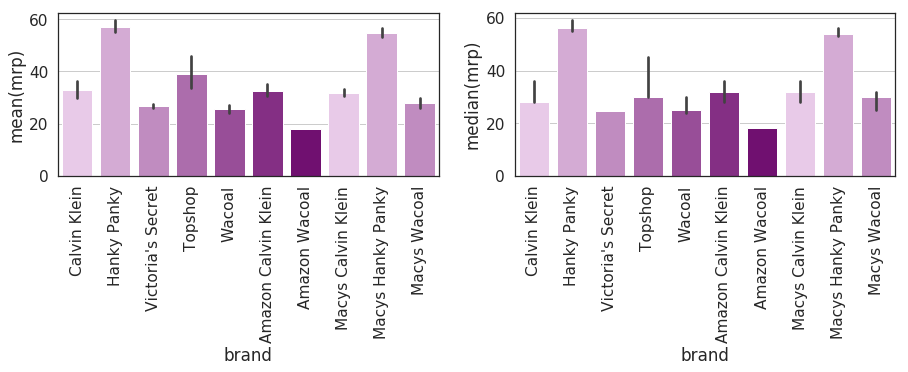

In [ ]:
category_plots(['bralettes'], brands_info, figsize1=(20,5),figsize2=(20,5), figsize3=(15,3))

**Question 15**: Bodys of which brand are the most expensive?
* And again Hanky Panky is most expensive one.
* The least expensive are sold by Victoria's Secret and Topshop.

brand   Hanky Panky        ...          Victoria's Secret
median  83.0               ...          58.0             

[1 rows x 5 columns]

brand  Hanky Panky        ...          Victoria's Secret
mean   94.294118          ...          54.25            

[1 rows x 5 columns]

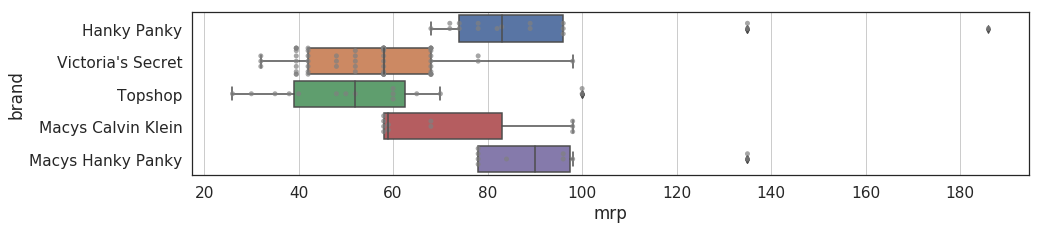

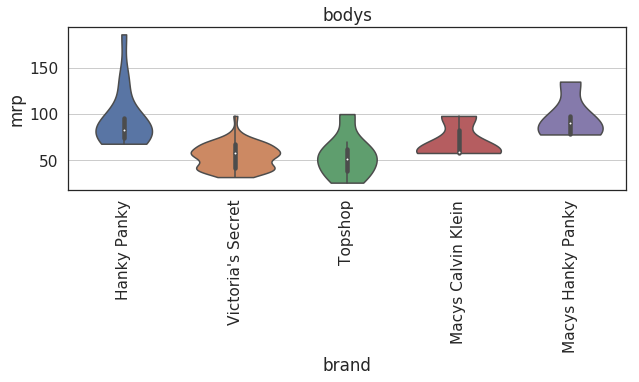

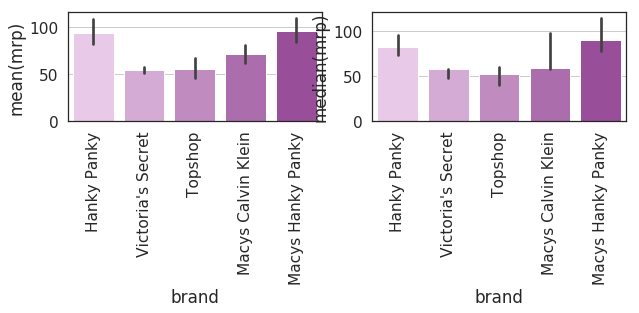

In [ ]:
category_plots(['bodys'], brands_info, figsize1=(15,3), figsize2=(10,3), figsize3=(10,2))

**Question 16**: Activewear of which brand is the most expensive?
* Macy's Wacoal is by far the most expensive brand in terms of activewear (mostly sport bras)
* Victoria's Secret and Calvin Klein are kind of on the same price level, however, the majority of the products are less expensive in Victoria's Secret
* Topshop is the cheapest brand in this category (but it has only 7 products)

brand   Amazon Victoria's Secret   ...    Wacoal
median  39.99                      ...    40.0  

[1 rows x 7 columns]

brand  Amazon Victoria's Secret  Calvin Klein   ...    Victoria's Secret  Wacoal
mean   44.04                     30.666667      ...    28.300287          40.0  

[1 rows x 7 columns]

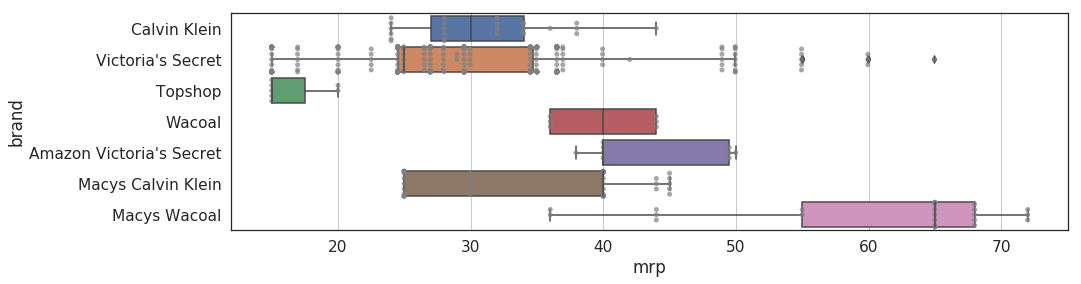

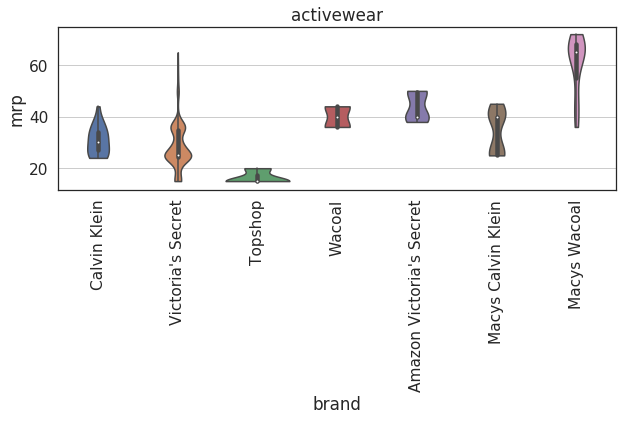

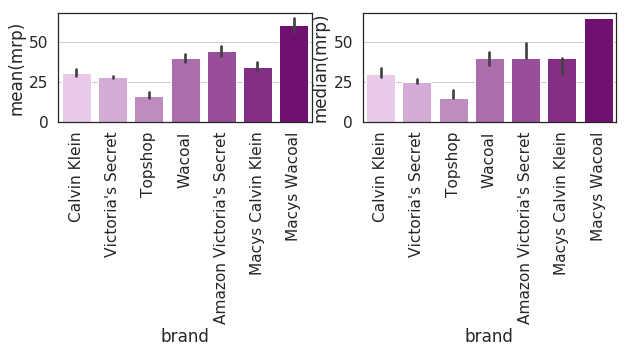

In [ ]:
category_plots(['activewear'], brands_info, figsize1=(15,4), figsize2=(10,3), figsize3=(10,2))

**Question 17**: Sleepwear of which brand are the most expensive?
* Hanky Panky has the most expensive products
* Victoria's Secret is less expensive than Calvin Klein.

brand   Calvin Klein        ...          Victoria's Secret
median  42.0                ...          28.0             

[1 rows x 4 columns]

brand  Calvin Klein        ...          Victoria's Secret
mean   46.085106           ...          35.111111        

[1 rows x 4 columns]

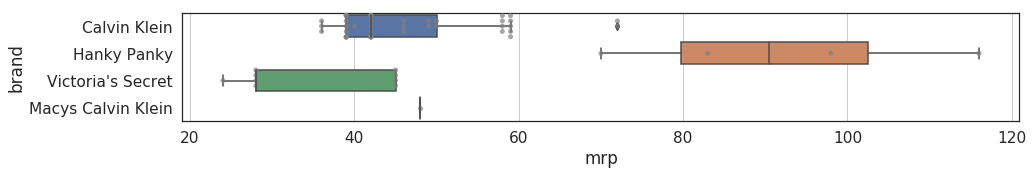

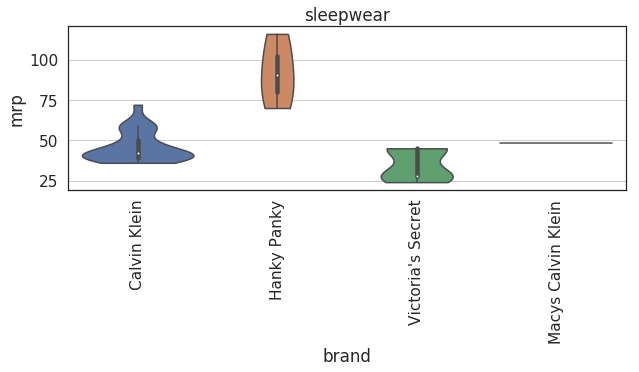

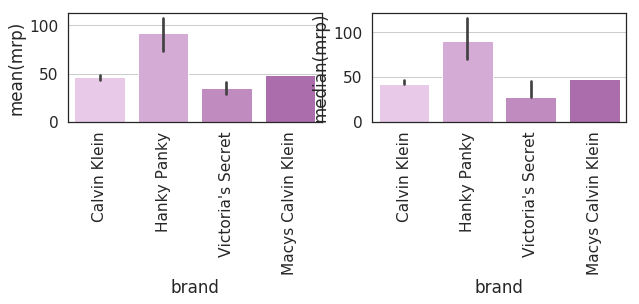

In [ ]:
category_plots(['sleepwear'], brands_info, figsize1=(15,2), figsize2=(10,3), figsize3=(10,2))

Hanky Panky is the most expensive brand in following categories: sleepwear, bralettes, panties and bras!
Macy's Wacoal sells the most expensive activewear.


****************************************
**Learnings**:<br>

**Bras**:<br>
Bras are on average of the same price approximatelly for other brands like Calvin Klein, Victoria's Secret, Topshop and Wacoal. However, some brands like Topshop, VS and Macys Wacoal have either a bimodal distribution (meaning they sell both: less expensive and expensive bras) or several big outliers.

**Panties**:<br>
The majority of Wacoal, Topshop, Calvin Klein and Victoria's Secret panties are around 10-15 USD.
Hanky Panky (OW and Amazon) has more expensive panties. 
The majority of Victoria's Secret panties tend to be the cheapest.

**Bralettes**:<br>
Victoria's Secret and Wacoal have the cheapest bralettes.

**Bodys**:<br>
Only 5 brands sell bodies. The least expensive are sold by Victoria's Secret and Topshop.

**Activwear**:<br>
Victoria's Secret and Calvin Klein are kind of on the same price level, however, the majority of the products are less expensive in Victoria's Secret
****************************************

**Question 18:** Is Victoria's Secret  or Calvin Klein cheaper?
At the begining we saw that Calvin Klein was a bit more expensive than Victoria's Secret but is it in all categories?

Sleepwear, activewear, panties and barlettes of Calvin Klein are more expensive than of Victoria's Secret.

In [ ]:
def barplots_extra(money, df, figsize3, xtitle = 'mrp', x = 'brand', hue = None, palette = light_purple[1:]):
    fig, axes = plt.subplots(nrows=2, ncols=1,figsize=figsize3)
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    ax = sns.barplot(y=money, x = x, hue = hue, data = df, palette = palette, ax = axes[0])
    ax.set_ylabel('mean(' + xtitle + ')', fontsize=13)
    ax.set_xlabel('category', fontsize=12)
    ax.yaxis.grid(True)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _= ax.tick_params(axis='both', which='major', labelsize=14)

    ax = sns.barplot(y=money, x = x, hue = hue, data = df, palette = palette, estimator=np.median, ax = axes[1])
    ax.set_ylabel('median(' + xtitle + ')', fontsize=13)
    display(df.groupby('brand')[money].agg({'median'}).transpose())
    ax.set_xlabel('category', fontsize=12)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _= ax.tick_params(axis='both', which='major', labelsize=14)
    ax.yaxis.grid(True)


brand   Calvin Klein  Victoria's Secret
median  22.0          20.0

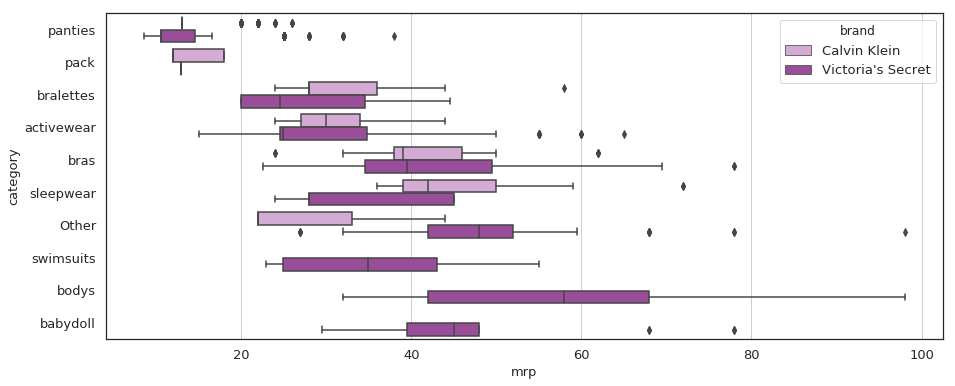

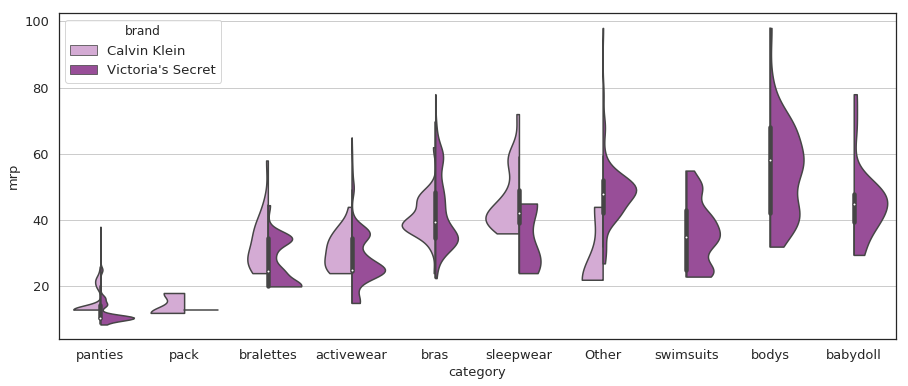

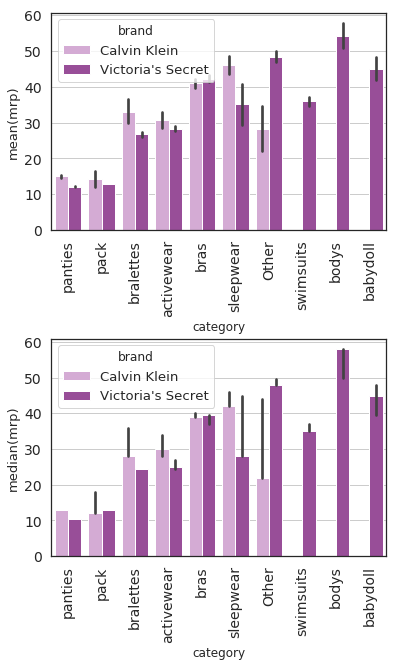

In [ ]:
sns.set(font_scale = 1.2)
sns.set_style('white', {'legend.frameon':True})
df = brands_info[brands_info['brand'].isin(['Calvin Klein', "Victoria's Secret"])]
df = df[df['product_category']!='Other']
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,6))
ax = sns.boxplot(y = 'category', x="mrp", hue='brand', data=df, ax=axes, palette = [light_purple[2], light_purple[5]])
#ax = sns.swarmplot(y = 'category', hue = 'brand', x="mrp", data=df, ax = axes, color = 'grey')
_= ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel('mrp', fontsize=13)
ax.set_ylabel('category', fontsize=13)
ax.xaxis.grid(True)
fig.savefig('calvin_victoria_boxplot.png')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,6))
ax = sns.violinplot(y="mrp", hue ='brand', x = 'category',cut = 0, split=True, data=df, ax = axes, palette = [light_purple[2], light_purple[5]])
ax.yaxis.grid(True)
_= ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_ylabel('mrp', fontsize=13)
ax.set_xlabel('category', fontsize=13)
fig.savefig('calvin_victoria_violin.png')

barplots_extra('mrp', df, (6,10), hue = 'brand', x='category', palette = [light_purple[2], light_purple[5]])


# 3. It is all about the discounts ...

## 3.1 Discount category
But in fact, when we shop we are searching for the discounts. Discounts will be defined as mrp - price as this is what we always see on the websites. There will be three discount categories: low (between 0 and 8), middle (between 9 and 17) and high (above 18).

Disclaimer: Because the data was scapped during two months, it might happen that discounts do not occur at the same time. (A bra could be discounted on 10.08 but had it normal mrp on 12.08 again and discount for some panties could start from the 14.08)

In [ ]:
def find_discount(data):
    data['diff'] = (data['mrp'] - data['price']).round(2)
    data['diff_categories'] = ''
    data.loc[(data['diff'] < 9) & (data['diff'] != 0.0), 'diff_categories'] = 'low'
    data.loc[(data['diff'] >= 9) & (data['diff'] < 18), 'diff_categories'] = 'middle'
    data.loc[(data['diff'] >= 18), 'diff_categories'] = 'high'
    data.loc[(data['diff'] == 0.0), 'diff_categories'] = 'no'   
    data['discount'] = "not discounted"
    data.loc[(data['diff'] > 0.0), 'discount'] = 'discounted'   
    return data

In [ ]:
brands_info = find_discount(brands_info)

In [ ]:
def stacked_all(data, category, name = None, discount_cat = 'diff_categories'):
    fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,10))
    tab = pd.crosstab(data[discount_cat], data[category]).transpose()
    if 'high (>=50%)' in tab.columns:
        ordering = ['high (>=50%)','middle (20%>=x<50%)','low (<20%)','no']
    else:
        ordering = ['high','middle','low','no']
    cor = [x for x in ordering if x in tab.columns] + [x for x in tab.columns if x not in ordering]
    tab = tab[cor]

    tab_prop = tab.div(tab.sum(1).astype(float), axis=0)  
    tab_pro = tab_prop.append(pd.DataFrame([1])).drop(0, axis=1) 
    display(tab_pro.transpose())
    ##f7caf2
    colors = ["#755791","#c06c84", "#f67280", "#f8b195"] 
    

    tab_pro.reindex(tab_pro.index.tolist()).plot(kind="bar", stacked=True, ax = ax[0], fontsize = 9, color = colors)  
    ax[0].yaxis.grid(True)
    df = tab.transpose()
    bbox=[0, 0, 1, 1]
    ax[1].axis('off')
    mpl_table = ax[1].table(cellText = df.values, rowLabels = df.index, 
                            colLabels=df.columns, bbox = bbox)

    plt.legend(fontsize=9)
    #ax[0].set_xlabel("Difference between RMP and price", fontsize = 10 )
    ax[0].set_title(name)


In [ ]:
def stacked_all(data, category, name = None):
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,3))
    tab = pd.crosstab(data['diff_categories'], data[category]).transpose()
    print(name)
    display(tab)

    tab_prop = tab.div(tab.sum(1).astype(float), axis=0)  
    tab_pro = tab_prop.append(pd.DataFrame([1])).drop(0, axis=1) 
    display(tab_pro.transpose())

    tab_pro.reindex(tab_pro.index.tolist()).plot(kind="bar", stacked=True, ax = ax, fontsize = 9)


**Question 19**: Which product category falls into which discount category?
* Around 56% of bras and activewear and 52% of bralettes are discounted. 
* Only 20% of panties are discounted (do not forget there are special offers like 3 for 33 USD etc)
* 25% of babydolls and 34% of bras have a high discount. 

None


diff_categories  high  low  middle    no
category                                
Other            50    9    22      256 
activewear       50    54   257     274 
babydoll         32    2    17      76  
bodys            19    0    8       86  
bralettes        106   103  190     379 
bras             412   10   246     537 
pack             8     13   28      111 
panties          7     550  164     2742
sleepwear        13    1    6       41  
swimsuits        22    0    32      170

Other  activewear  babydoll ...  sleepwear  swimsuits   0
high    0.148368  0.078740    0.251969 ...  0.213115   0.098214  NaN
low     0.026706  0.085039    0.015748 ...  0.016393   0.000000  NaN
middle  0.065282  0.404724    0.133858 ...  0.098361   0.142857  NaN
no      0.759644  0.431496    0.598425 ...  0.672131   0.758929  NaN

[4 rows x 11 columns]

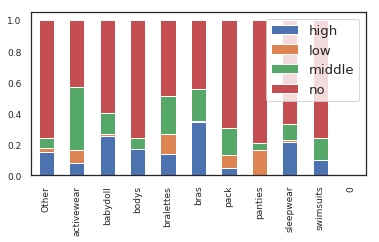

In [ ]:
stacked_all(brands_info, 'category')

brand           Amazon Calvin Klein   ...    Wacoal
discount                              ...          
discounted      107                   ...    216   
not discounted  19                    ...    161   

[2 rows x 12 columns]

Amazon Calvin Klein    ...       Wacoal
discounted      0.849206               ...     0.572944
not discounted  0.150794               ...     0.427056

[2 rows x 12 columns]

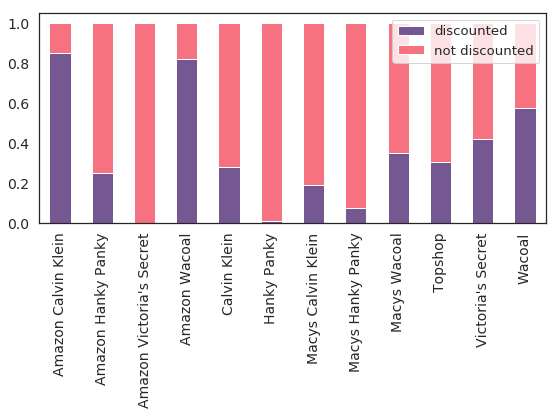

In [ ]:
tab = pd.crosstab(brands_info['discount'], brands_info['brand']).transpose()
display(tab.transpose())

tab_prop = tab.div(tab.sum(1).astype(float), axis=0)  
tab_pro = tab_prop.append(pd.DataFrame([1])).drop(0,axis=1) 
tab_pro.drop(tab_pro.index[12], inplace = True)
display(tab_pro.transpose())
colors = ["#755791", "#f67280"]
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))
_ = tab_pro.reindex(tab_pro.index.tolist()).plot(kind="bar", stacked=True, ax = ax, fontsize = 12, color = colors)
_= ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
fig.savefig('percent_discount.png')


In [ ]:
def stacked_all_brands(data, discount_cat = 'diff_categories', figsize = (15,5)):
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=figsize)
    tab = pd.crosstab(data[discount_cat], data['brand']).transpose()
    if 'high (>=50%)' in tab.columns:
        ordering = ['high (>=50%)','middle (20%>=x<50%)','low (<20%)','no']
    else:
        ordering = ['high','middle','low','no']
    cor = [x for x in ordering if x in tab.columns] + [x for x in tab.columns if x not in ordering]
    tab = tab[cor]
    display(tab.transpose())

    tab_prop = tab.div(tab.sum(1).astype(float), axis=0)  
    tab_pro = tab_prop.append(pd.DataFrame([1])).drop(0, axis=1) 
    display(tab_pro.transpose())
    ##f7caf2
    colors = ["#755791","#c06c84", "#f67280", "#f8b195"] 
    tab_pro.reindex(tab_pro.index.tolist()).plot(kind="bar", stacked=True, ax = ax, fontsize = 9, color = colors)
    ax.yaxis.grid(True)

## 3.2 Who offers larger discount?
**Question 21**: Which brands offer larger discounts?
We will take into consideration only brands with high number of discounted products.

* Victoria's Secret, Macys Calvin Klein and Topshop  have several really large discounts (over 40 USD).
* Hanky Panky (OW and Macys) seems to have the larger (average amd median) discount but only because there is a negligible number of discounted items in total.

brand   Amazon Calvin Klein   ...    Wacoal
median  10.03                 ...    6.6   

[1 rows x 11 columns]

brand  Amazon Calvin Klein    ...       Wacoal
mean   11.003458              ...     8.538426

[1 rows x 11 columns]

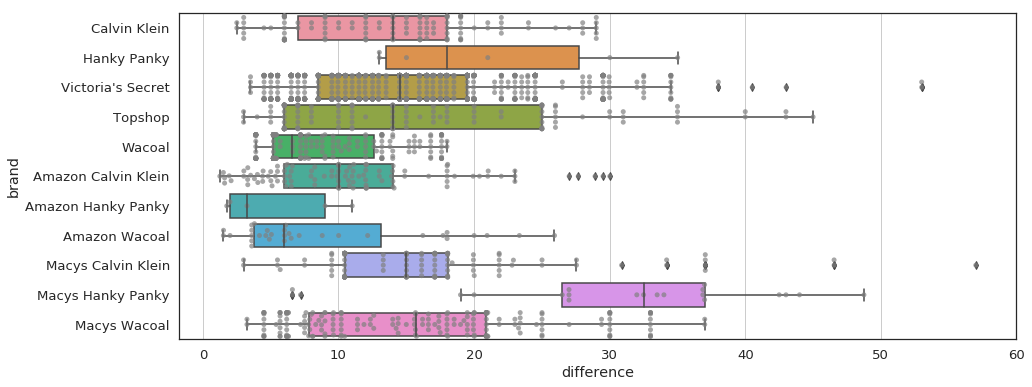

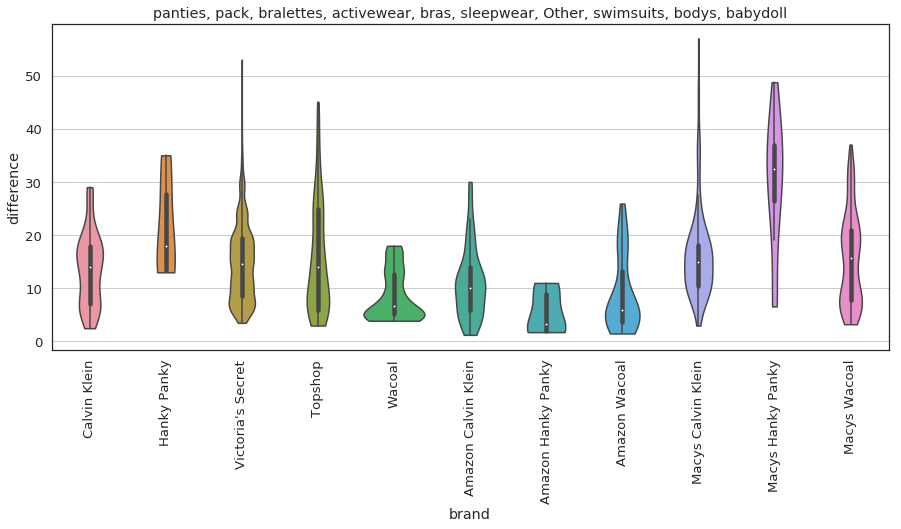

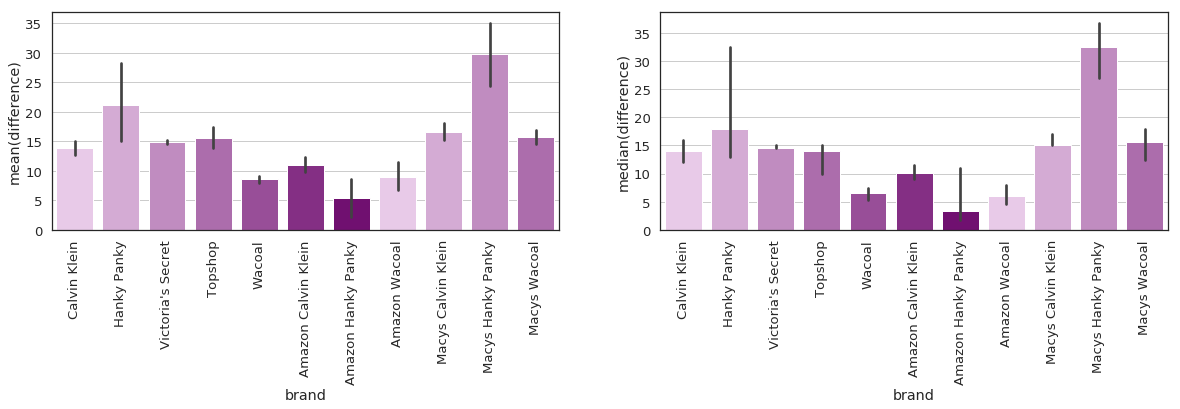

In [ ]:
df = brands_info[brands_info['diff']>0]
category_plots(brands_info['category'].unique(), df, swarm = True, money = 'diff', xtitle = 'difference')

**Question 22**: What are the products with a discount over 40 USD?
As expected, that are a bit more expensive items like bras, barlettes, babydools and one romper.

In [ ]:
brands_info[brands_info['diff']>40][['product_name','brand','category','diff', 'price', 'mrp', 'color']]

product_name            ...                                color
3583  very sexy strappy plunge bra                                                ...             evening tide with ensign
3801  very sexy lace plunge garter slip                                           ...             red lacquer             
3802  very sexy lace plunge garter slip                                           ...             black                   
4227  very sexy embroidered triangle bra                                          ...             black                   
4791  bra by bluebella                                                            ...             black                   
4799  mesh bralet by somedays lovin'                                              ...             black                   
4819  lacey body                                                                  ...             black                   
6197  ck collection black daring silk chemise qs5552                              ...             black                   
6198  ck black collection temptation floral embroidered chemise qs5555            ...             black                   
6221  ck black collection temptation silk romper qs5495                           ...             black                   
6358  dahlia embroidered mesh bralette 297132                                     ...             navy pink               
6368  bahama mama sheer lace bralette 957902                                      ...             peacock passionate pink 
6439  signature lace chemise 485776                                               ...             black                   
6440  fitted signature lace chemise 485706                                        ...             calypso                 

[14 rows x 7 columns]

Some of the most discounted items:

In [ ]:
html = "<table><tr><td>Victorias Secret: bra<img src='https://images-na.ssl-images-amazon.com/images/I/713DKKJk4dL._UY445_.jpg' style='width: 200px;'></td><td>Victorias Secret: slip<img src='https://images-na.ssl-images-amazon.com/images/I/61CWtyQDgjL._UL1500_.jpg' style='width: 200px;'></td><td>Topshop: bra by bluebella<img src='http://media.topshop.com/wcsstore/TopShopDE/images/catalog/TS43C62LBLK_Zoom_F_1.jpg' style='width: 200px;'></td></tr></table>"
display(HTML(html))

**Question 23:** What is the the least discounted item?
That is the panty from Amazon Calvin Klein that has been discounted only by 1.25 USD.

In [ ]:
html = "<table><tr><td>Amazon Calvin Klein: least discounted panty<img src='https://images-na.ssl-images-amazon.com/images/I/81AmIezUmWL._UL1500_.jpg' style='width: 200px;'></td></tr></table>"
display(HTML(html))

In [ ]:
min_diff = np.min(brands_info[brands_info['diff']>0]['diff'])
brands_info[brands_info['diff']==min_diff]

Unnamed: 0   mrp  price     ...      diff diff_categories    discount
5436  5436        13.0  11.75     ...      1.25  low             discounted

[1 rows x 14 columns]

## 3.3 Ratio of RMP to the price. Real discount value.

Large discounts are good but no panties would get into high level discount unless they cost around 40 euros. As we have seen the average price of the panties is around 15 dollars. It will be more informative to look at the percentage of the offered discount to the price. So, if the rmp is 14 dollars and price is 7 dollars. There is a 50% discount.

In [ ]:
def find_percentage_discount(data):
    data['diff_per'] = (data['diff'] * 100  / data['mrp']).round(2)  

    data['diff_per_categories'] = ''
    data.loc[(data['diff_per'] < 20) & (data['diff_per'] != 0.0), 'diff_per_categories'] = 'low (<20%)'
    data.loc[(data['diff_per'] >= 20) & (data['diff_per'] < 50), 'diff_per_categories'] = 'middle (20%>=x<50%)'
    data.loc[(data['diff_per'] >= 50), 'diff_per_categories'] = 'high (>=50%)'
    data.loc[(data['diff_per'] == 0.0), 'diff_per_categories'] = 'no'   
    return data

In [ ]:
brands_info = find_percentage_discount(brands_info)

## 3.3.1 Which brand offers which percentage discount?

**Question 24.1 :** Sales! Up to 50%. What percentage discounts are offered by each brand?
* The majority of Victoria's Secret discounts are around 50%, having an outlier with >=80% discount!
* Topshop has a bimodal distribution with discounts around 40% and 60-70% but with a median of 50%.
* Calvin Klein has most of the discounts around 46% and Amazon Calvin Klein around 36% but Amazon has more items with >=50% discount.
* Wacoal offers either 30% or 40% discounts and Macy's Wacoal has also a bimodal distribution with around 30%  and 45% discount.
* Hanky Panky does not offer much of the discount.


brand   Amazon Calvin Klein   ...    Wacoal
median  36.75                 ...    40.0  

[1 rows x 11 columns]

brand  Amazon Calvin Klein    ...         Wacoal
mean   37.463271              ...      36.435185

[1 rows x 11 columns]

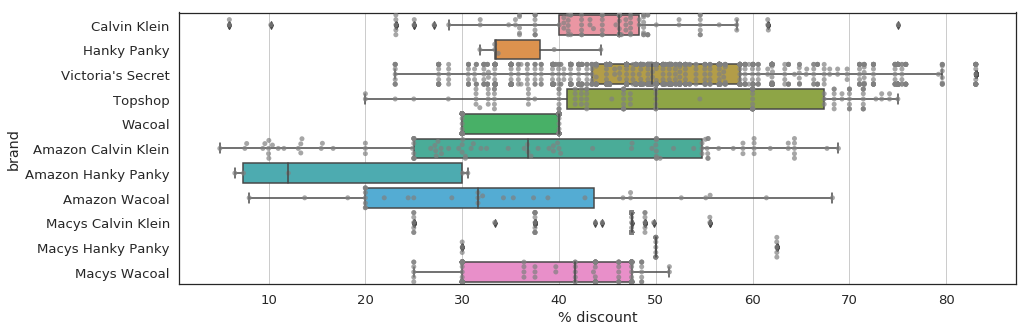

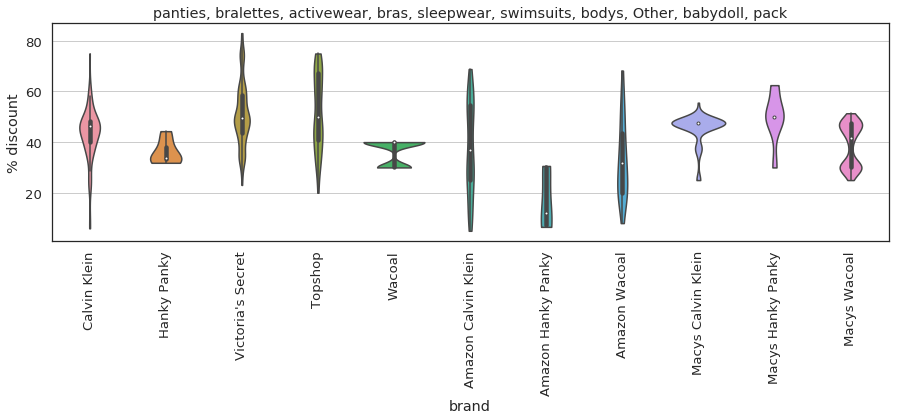

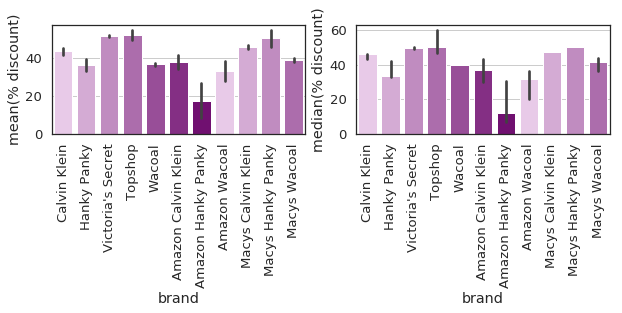

In [ ]:
df = brands_info
df = df[df['diff_per']>0]
category_plots(df['category'].unique(), df, swarm = True, money = 'diff_per', xtitle='% discount',
               figsize1=(15,5), figsize2=(15,4), figsize3=(10,2))

In [ ]:
df[df['diff_per']>50].groupby('brand').size()

brand
Amazon Calvin Klein    39 
Amazon Wacoal          5  
Calvin Klein           18 
Macys Calvin Klein     2  
Macys Hanky Panky      5  
Macys Wacoal           2  
Topshop                58 
Victoria's Secret      716
dtype: int64

In [ ]:
df = brands_info[brands_info['diff_per']>=75]
df.drop_duplicates(['product_name','price','mrp','description'])[['product_name','price','mrp', 'diff_per', 'color', 'brand']]

product_name        ...                      brand
0     modern cotton bikini                                     ...          Calvin Klein     
1122  very sexy lace v string panty                            ...          Victoria's Secret
1124  dream angels ruffled cheekini bloomer panty              ...          Victoria's Secret
1220  very sexy strappy lace cheeky panty                      ...          Victoria's Secret
1221  dream angels ruffled thong panty                         ...          Victoria's Secret
1269  the bralette collection mesh plunge bralette             ...          Victoria's Secret
1270  the player lace up sport bra                             ...          Victoria's Secret
1271  victoria sport lightweight by victoria sport bra         ...          Victoria's Secret
1272  the bralette collection mesh scoopneck bralette          ...          Victoria's Secret
1278  the bralette collection scoopneck bralette               ...          Victoria's Secret
1284  the bralette collection mesh front close bralette        ...          Victoria's Secret
1292  the bralette collection crisscross scoop bralette        ...          Victoria's Secret
1310  the bralette collection lace scoopneck bralette          ...          Victoria's Secret
1312  the bralette collection bandeau flounce bralette         ...          Victoria's Secret
1313  victoria sport strappy triangle sport bra                ...          Victoria's Secret
1441  pink lace lightly lined triangle                         ...          Victoria's Secret
1689  sleep kimono                                             ...          Victoria's Secret
4604  full lace knickers                                       ...          Topshop          

[18 rows x 6 columns]

**Question 24.2 :** Sales! Up to 50%. What percentage discounts are common for each category?<br>
As most of the items come from Victoria's Secret those graphs are strongly influned by this brand.

* Panties, bralettes, bras, activwear have almost the same average discount (around 50%). However, more panties have a discount >=60% than any another catergory.
* Some swimsuits are more discounted (over 55%) than the others (less than 50%).
* Bodys, babydolls, Other and pack have a median discount around 40%.

brand   Amazon Calvin Klein   ...    Wacoal
median  36.75                 ...    40.0  

[1 rows x 11 columns]

brand  Amazon Calvin Klein    ...         Wacoal
mean   37.463271              ...      36.435185

[1 rows x 11 columns]

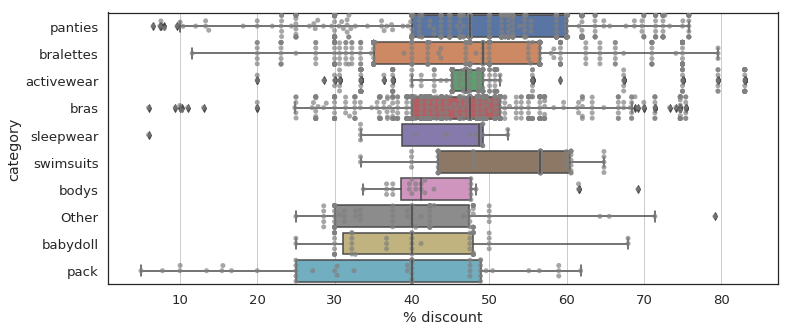

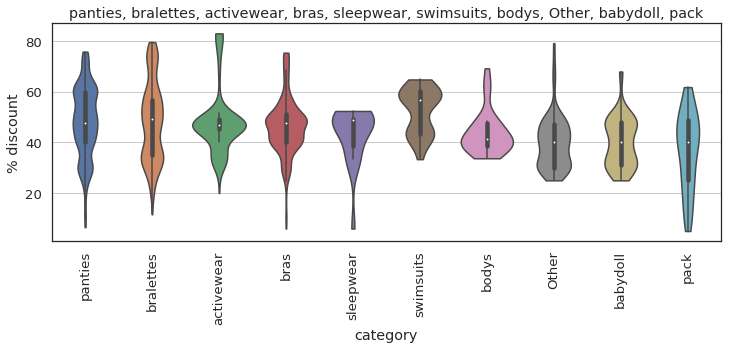

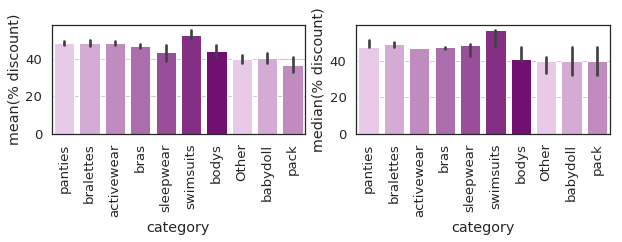

In [ ]:
df = brands_info
df = df[df['diff_per']>0]
category_plots(df['category'].unique(), df, y='category',swarm = True, money = 'diff_per', xtitle='% discount',
               figsize1=(12,5), figsize2=(12,4), figsize3=(10,2))

In [ ]:
df[df['diff_per']>60].groupby('category').size()

category
Other         4  
activewear    44 
babydoll      2  
bodys         3  
bralettes     78 
bras          67 
pack          1  
panties       173
swimsuits     14 
dtype: int64

In [ ]:
#**Question 25:** Sales! Up to 50%. What percentage disconts are offered by each brand for each category?
#* Around 20% (709) of panties have a discount >=20% (with 10% (348) of panties having >=50% discount)
#* 15% (190) of bras, 24% (193) of bralettes, 14% (32) of swimsuits and 12% (78) of activewear have a >=50% discount.
#stacked_all(brands_info, 'category', name = 'All Brands', discount_cat='diff_per_categories')

**Question 26:** Which brand offers larger percentage discount on each category?

## Panties
* _more than 50% discount_: 44% (22) of Amazon Calvin Klein, 17% (37) of Topshop and 16% (278) of Victoria's Secret 
* _more than 20% discount_: 76% (38) of Amazon Calvin Klein, 35% (54) of Topshop and 18.8% (310) of Victoria's Secret, 18% (46) of Calvin Klein, 16% (49) of Macy Calvin Klein


* Victoria's Secret offers the largest average discount on panties.


Learnings: 
* If you are a fan of Calvin Klein, I would firstly check Amazon Calvin Klein as they might have more highly discounted items but OW has more panties in general. And do not forget the packs (but Calvin Klein had also an offer "3 for 33").
* If you like Wacoal, check first OW because the majority of panties will have a discount around 40% but Macys might have more products with >45% discount  
* If you want hunting for the discounts, go to Victoria's Secret for panties.


brand                Amazon Calvin Klein   ...    Wacoal
diff_per_categories                        ...          
high (>=50%)         22                    ...    0     
middle (20%>=x<50%)  16                    ...    122   
low (<20%)           6                     ...    0     
no                   6                     ...    86    

[4 rows x 11 columns]

Amazon Calvin Klein  Amazon Hanky Panky ...    Wacoal   0
high (>=50%)         0.44                 0.00               ...  0.000000 NaN
middle (20%>=x<50%)  0.32                 0.10               ...  0.586538 NaN
low (<20%)           0.12                 0.15               ...  0.000000 NaN
no                   0.12                 0.75               ...  0.413462 NaN

[4 rows x 12 columns]

brand   Amazon Calvin Klein   ...    Wacoal
median  48.8                  ...    40.0  

[1 rows x 11 columns]

brand  Amazon Calvin Klein    ...         Wacoal
mean   40.532727              ...      36.311475

[1 rows x 11 columns]

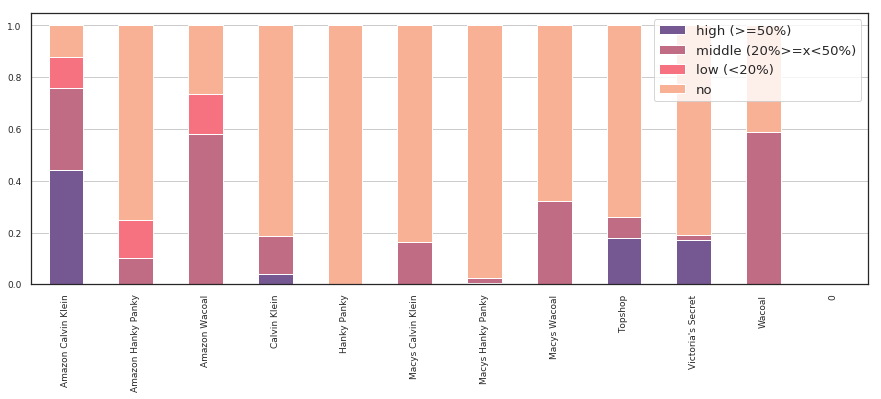

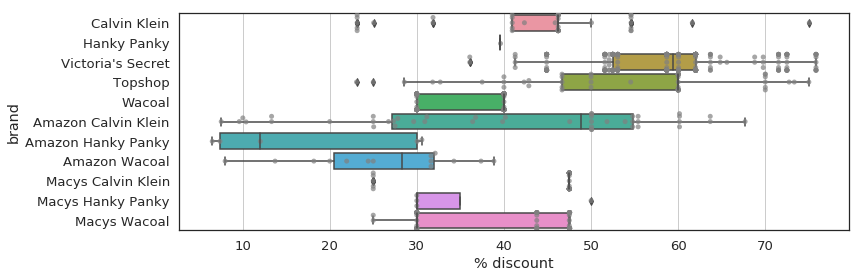

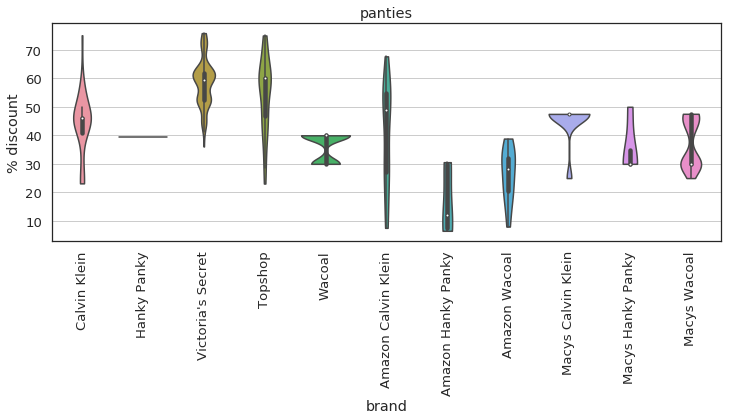

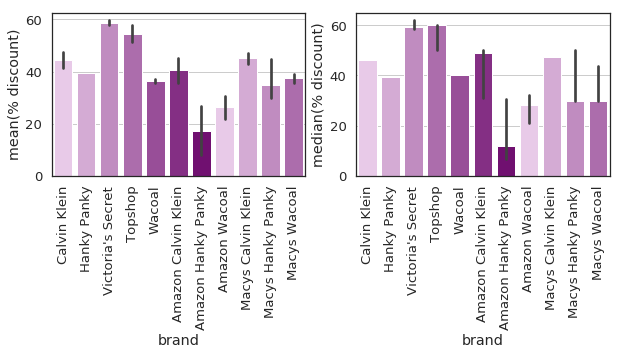

In [ ]:
def perform_viz(category, figsize1=(12,4), figsize2=(12,4), figsize3=(10,3)):
    df = brands_info
    df1 = df[df['category']==category]
    stacked_all_brands(df1, discount_cat='diff_per_categories')
    df1 = df[df['diff_per']>0]
    category_plots([category], df1, swarm = True, money = 'diff_per', xtitle = '% discount',
               figsize1=figsize1, figsize2=figsize2, figsize3=figsize3)
    
perform_viz('panties')

## Bras
* _more than 50% discount_: 16% (4) of Amazon Calvin Klein, 17% (22) of Topshop and 33% (156) of Victoria's Secret 
* _more than 20% discount_: 48% (16) of Amazon Calvin Klein, 36% (47) of Topshop and 85% (405) of Victoria's Secret, 50% (46) of Calvin Klein, 17% (28) of Macy Calvin Klein, 30% (67) of Macys Wacoal, 50% (41) of Wacoal <br>
<br>
* Victoria's Secret offers the largest relative number of discounted bras.
* Most bras of Victoria's Secret have a discount of 49%
* Topshop and Victoria's Secret offer more products with a discount over 50% than other brands.
* Macys Calvin Klein has a discount of around 47% on most of their discounted bras. Calvin Klein has more discounted bra but with around 42% discount, however, it still has outliers.
* Wacoal has again a bimodal discount distribution around 30% and 40%


Learnings: 
* Check Topshop and Victoria's Secret for (highly) discounted bras.
* If you like Wacoal, check first Macys as the majority of items have a discount of 46%, comparing to Wacoal's 40% (as well as the average discount is around 42% at Macys in comparison to OW with 37%)
* For Calvin Klein check both websites.

brand                Amazon Calvin Klein   ...    Wacoal
diff_per_categories                        ...          
high (>=50%)         4                     ...    0     
middle (20%>=x<50%)  12                    ...    41    
low (<20%)           4                     ...    0     
no                   5                     ...    40    

[4 rows x 9 columns]

Amazon Calvin Klein  Amazon Wacoal ...    Wacoal   0
high (>=50%)         0.16                 0.307692      ...  0.000000 NaN
middle (20%>=x<50%)  0.48                 0.461538      ...  0.506173 NaN
low (<20%)           0.16                 0.076923      ...  0.000000 NaN
no                   0.20                 0.153846      ...  0.493827 NaN

[4 rows x 10 columns]

brand   Amazon Calvin Klein  Amazon Wacoal   ...    Victoria's Secret  Wacoal
median  28.23                47.39           ...    49.39              40.0  

[1 rows x 9 columns]

brand  Amazon Calvin Klein    ...         Wacoal
mean   32.3895                ...      37.073171

[1 rows x 9 columns]

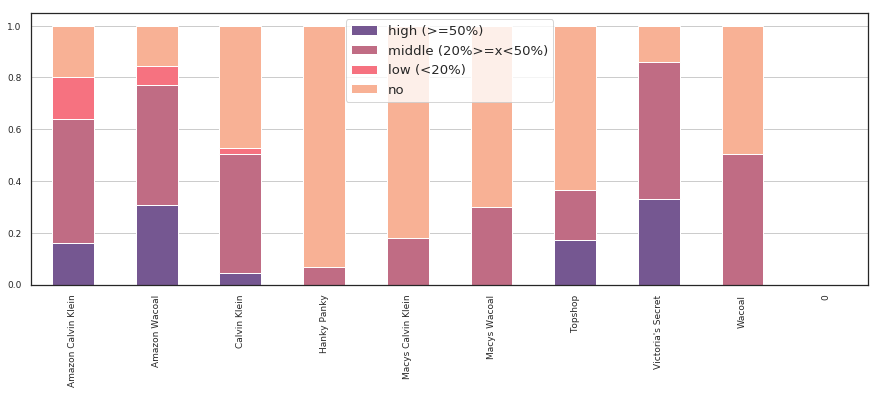

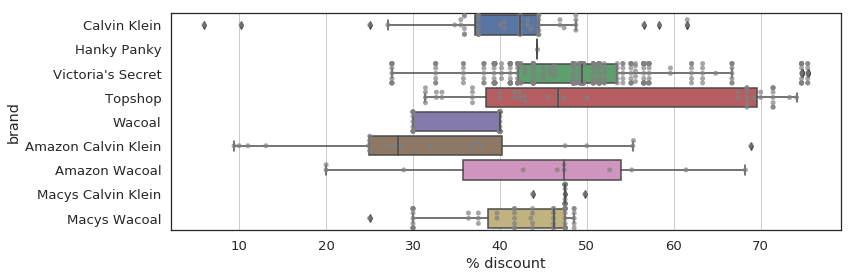

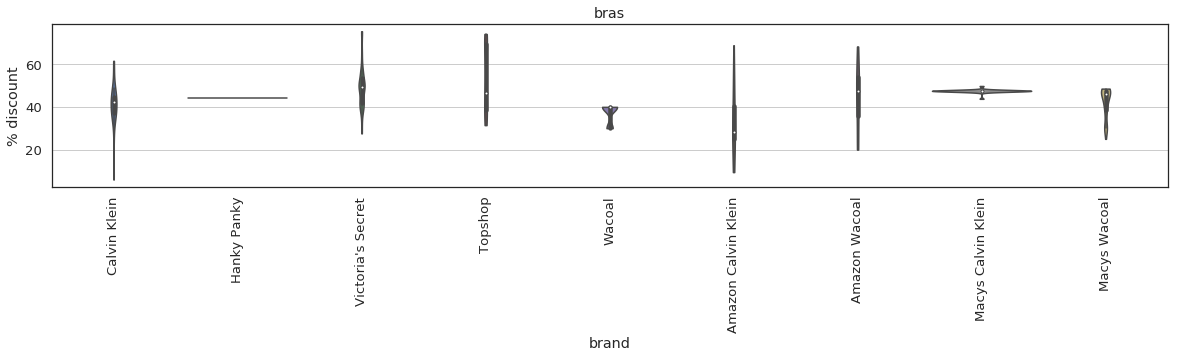

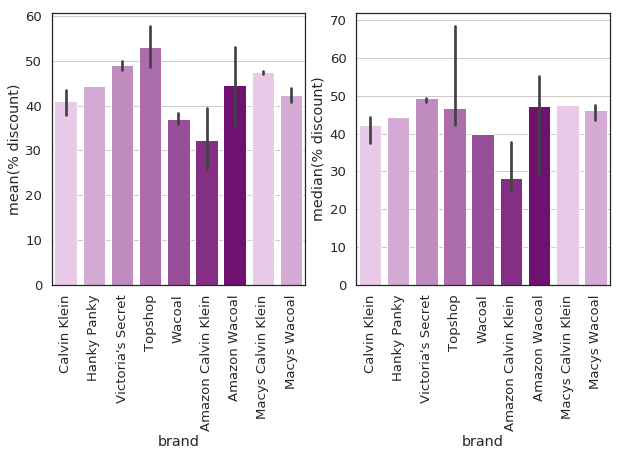

In [ ]:
perform_viz('bras',figsize1=(12,4), figsize2=(20,3), figsize3=(10,5))

## Bralettes

brand                Amazon Calvin Klein   ...    Wacoal
diff_per_categories                        ...          
high (>=50%)         7                     ...    0     
middle (20%>=x<50%)  6                     ...    24    
low (<20%)           1                     ...    0     
no                   0                     ...    25    

[4 rows x 10 columns]

Amazon Calvin Klein  Amazon Wacoal ...    Wacoal   0
high (>=50%)         0.500000             0.142857      ...  0.000000 NaN
middle (20%>=x<50%)  0.428571             0.857143      ...  0.489796 NaN
low (<20%)           0.071429             0.000000      ...  0.000000 NaN
no                   0.000000             0.000000      ...  0.510204 NaN

[4 rows x 11 columns]

brand   Amazon Calvin Klein  Amazon Wacoal   ...    Victoria's Secret  Wacoal
median  49.415               20.0            ...    50.05              30.0  

[1 rows x 10 columns]

brand  Amazon Calvin Klein    ...         Wacoal
mean   45.985714              ...      34.583333

[1 rows x 10 columns]

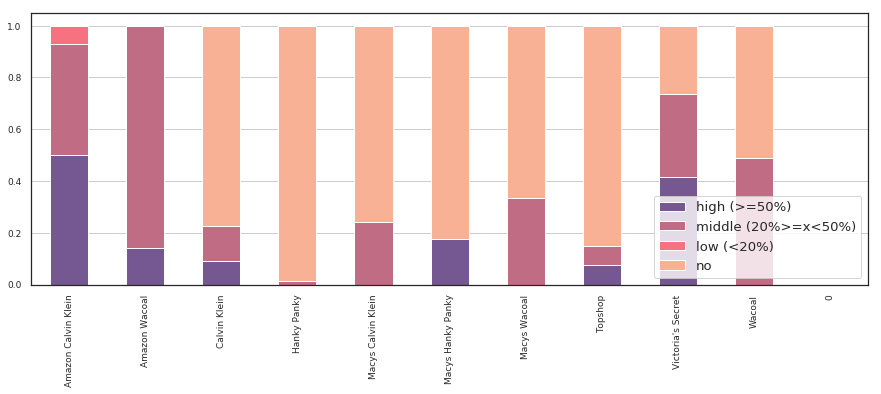

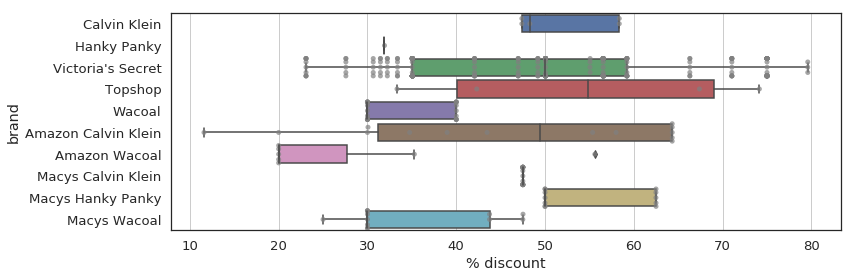

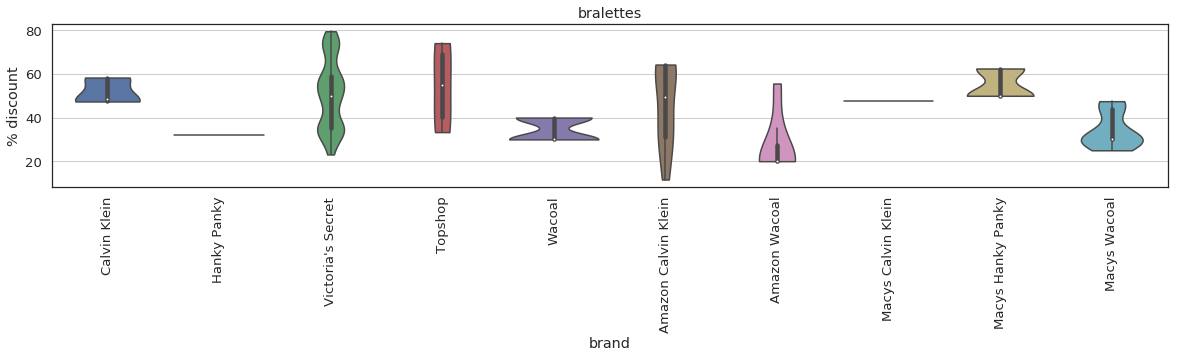

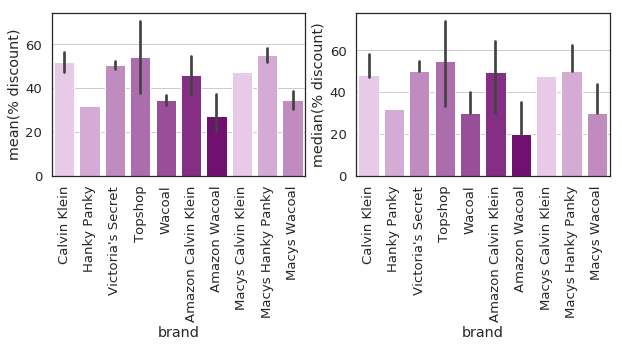

In [ ]:
perform_viz('bralettes', figsize1=(12,4), figsize2=(20,3), figsize3=(10,3))

## Activewear

brand                Amazon Victoria's Secret   ...    Wacoal
diff_per_categories                             ...          
high (>=50%)         0                          ...    0     
middle (20%>=x<50%)  0                          ...    5     
no                   9                          ...    1     

[3 rows x 7 columns]

Amazon Victoria's Secret  Calvin Klein ...    Wacoal   0
high (>=50%)         0.0                       0.000000     ...  0.000000 NaN
middle (20%>=x<50%)  0.0                       0.458333     ...  0.833333 NaN
no                   1.0                       0.541667     ...  0.166667 NaN

[3 rows x 8 columns]

brand   Calvin Klein  Macys Calvin Klein   ...    Victoria's Secret  Wacoal
median  41.21         37.52                ...    46.98              30.0  

[1 rows x 6 columns]

brand  Calvin Klein  Macys Calvin Klein   ...    Victoria's Secret  Wacoal
mean   42.077273     39.951875            ...    49.468424          34.0  

[1 rows x 6 columns]

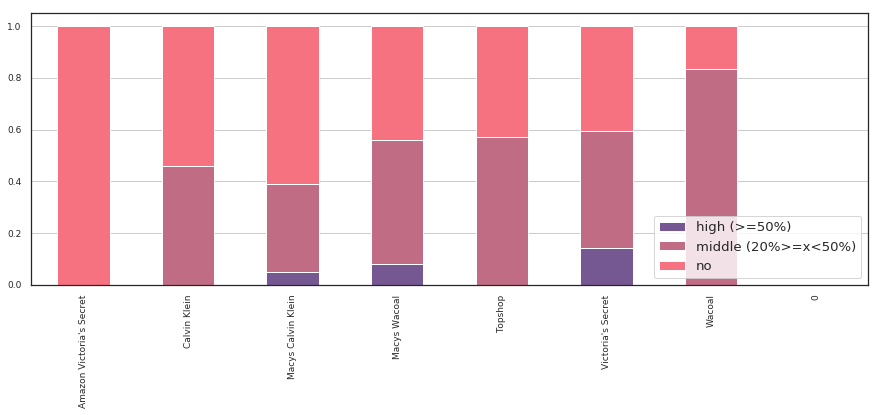

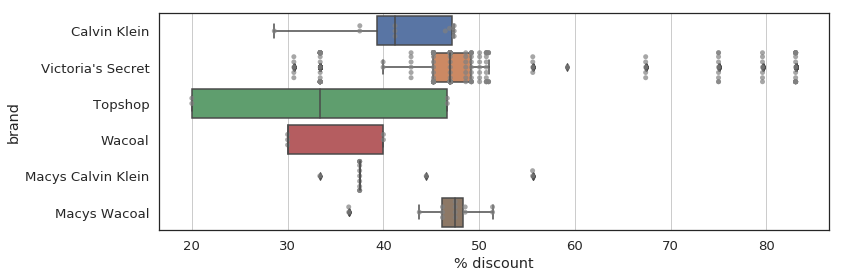

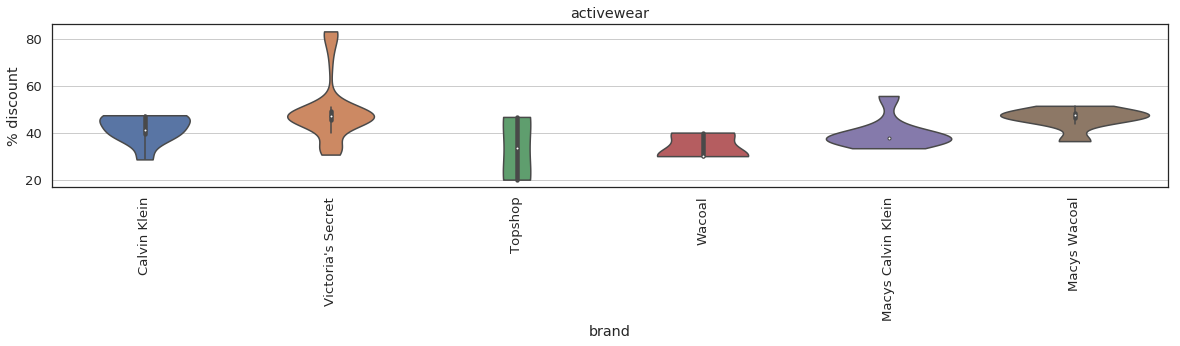

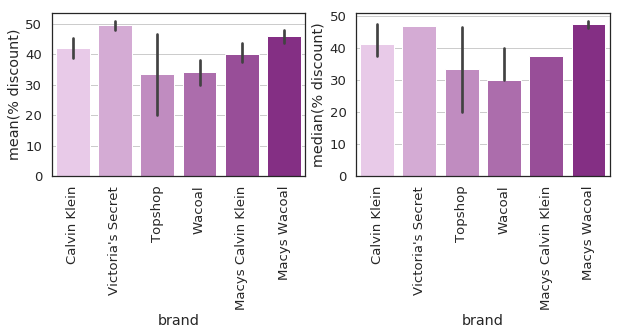

In [ ]:
perform_viz('activewear', figsize1=(12,4), figsize2=(20,3), figsize3=(10,3))

## Packs
* Majority of packs from Amazon Calvin Klein are discounted.

brand                Amazon Calvin Klein   ...    Wacoal
diff_per_categories                        ...          
high (>=50%)         7                     ...    0     
middle (20%>=x<50%)  14                    ...    9     
low (<20%)           8                     ...    0     
no                   7                     ...    0     

[4 rows x 9 columns]

Amazon Calvin Klein  Calvin Klein ...  Wacoal   0
high (>=50%)         0.194444             0.0          ...  0.0    NaN
middle (20%>=x<50%)  0.388889             0.0          ...  1.0    NaN
low (<20%)           0.222222             0.0          ...  0.0    NaN
no                   0.194444             1.0          ...  0.0    NaN

[4 rows x 10 columns]

brand   Amazon Calvin Klein  Macys Calvin Klein  Macys Wacoal  Wacoal
median  30.0                 48.88               47.52         40.0

brand  Amazon Calvin Klein  Macys Calvin Klein  Macys Wacoal  Wacoal
mean   32.191034            45.468571           47.52         40.0

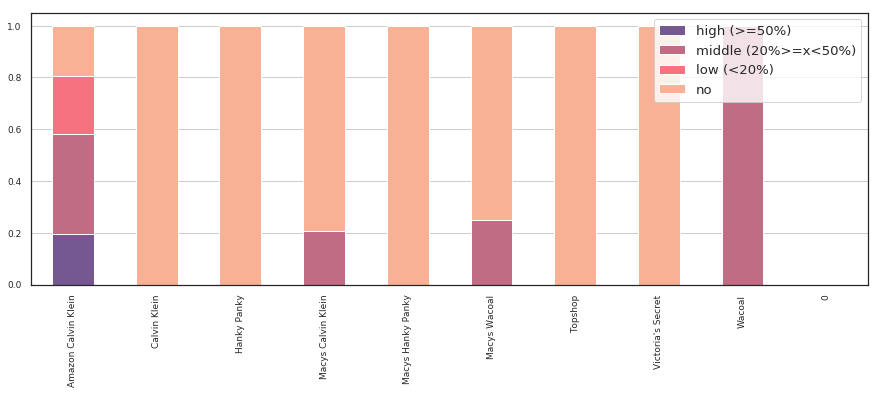

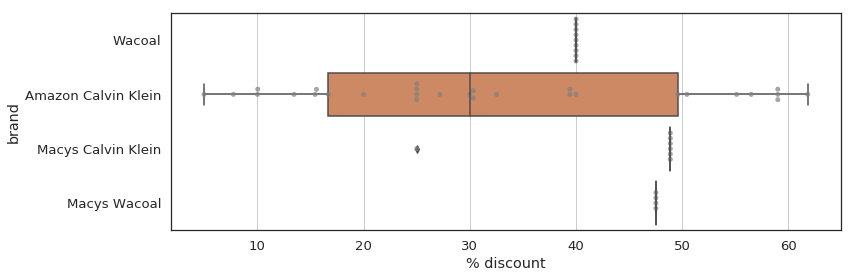

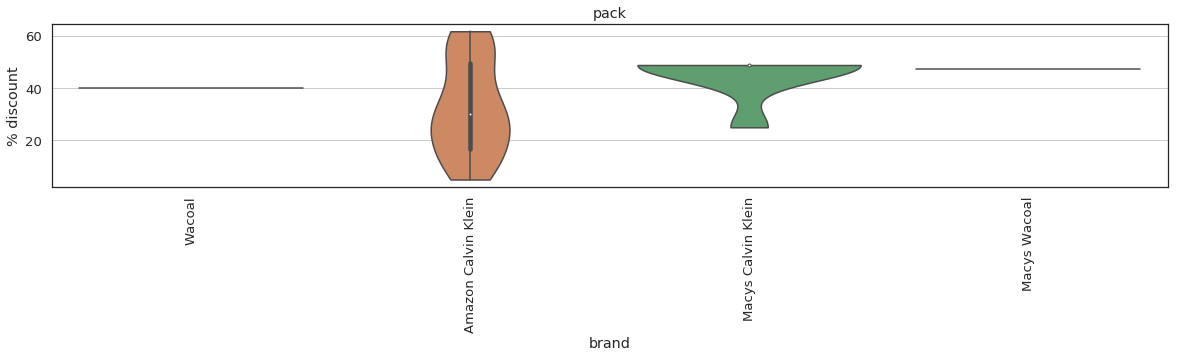

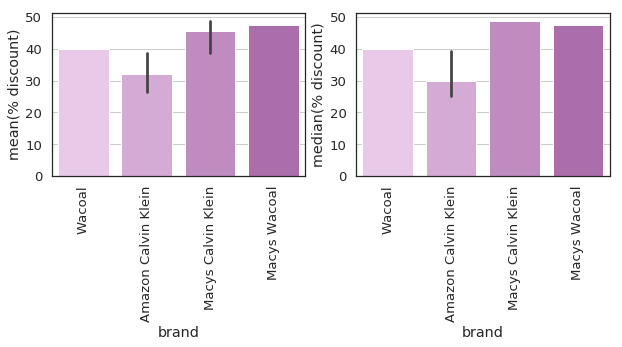

In [ ]:
perform_viz('pack', figsize1=(12,4), figsize2=(20,3), figsize3=(10,3))

## Sleepwear

brand                Calvin Klein        ...          Victoria's Secret
diff_per_categories                      ...                           
high (>=50%)         2                   ...          0                
middle (20%>=x<50%)  12                  ...          4                
low (<20%)           1                   ...          0                
no                   32                  ...          5                

[4 rows x 4 columns]

Calvin Klein  Hanky Panky ...  Victoria's Secret   0
high (>=50%)         0.042553      0.0         ...  0.000000          NaN
middle (20%>=x<50%)  0.255319      0.0         ...  0.444444          NaN
low (<20%)           0.021277      0.0         ...  0.000000          NaN
no                   0.680851      1.0         ...  0.555556          NaN

[4 rows x 5 columns]

brand   Calvin Klein  Macys Calvin Klein  Victoria's Secret
median  48.74         47.5                33.36

brand  Calvin Klein  Macys Calvin Klein  Victoria's Secret
mean   45.654667     47.5                33.36

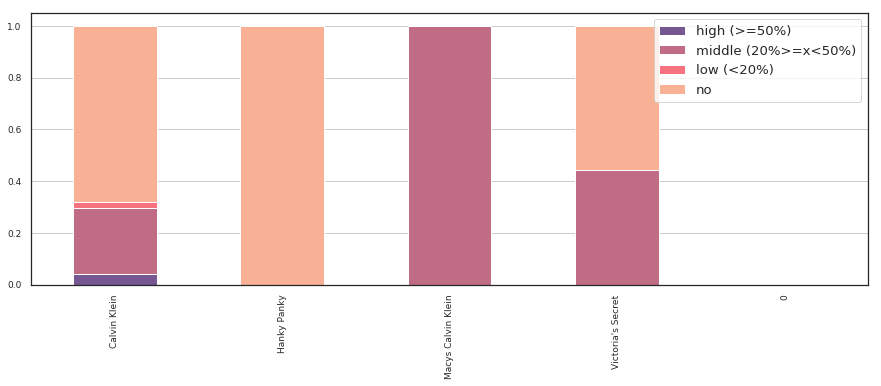

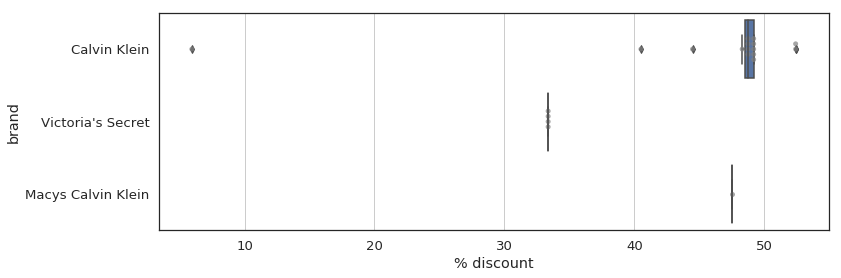

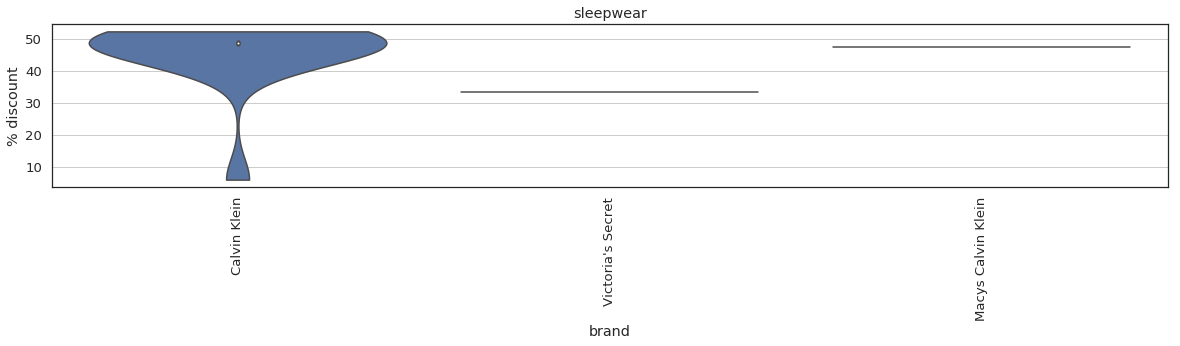

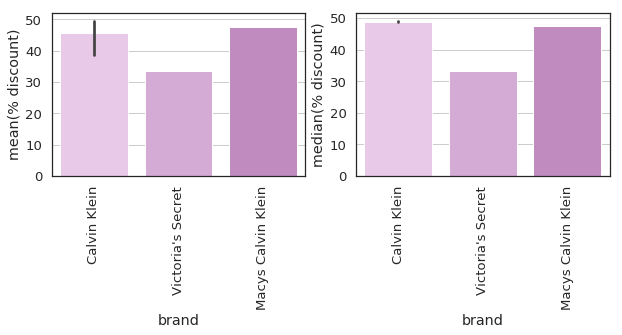

In [ ]:
perform_viz('sleepwear', figsize1=(12,4), figsize2=(20,3), figsize3=(10,3))

**Other categories**

brand                Hanky Panky   ...    Wacoal
diff_per_categories                ...          
high (>=50%)         0             ...    0     
middle (20%>=x<50%)  3             ...    15    

[2 rows x 7 columns]

Hanky Panky  Macys Calvin Klein ...  Wacoal   0
high (>=50%)         0.0          0.0                ...  0.0    NaN
middle (20%>=x<50%)  1.0          1.0                ...  1.0    NaN

[2 rows x 8 columns]

brand   Hanky Panky  Macys Calvin Klein   ...    Victoria's Secret  Wacoal
median  33.36        47.5                 ...    47.64              40.0  

[1 rows x 7 columns]

brand  Hanky Panky  Macys Calvin Klein    ...      Victoria's Secret     Wacoal
mean   33.48        41.875                ...      46.710791          37.333333

[1 rows x 7 columns]

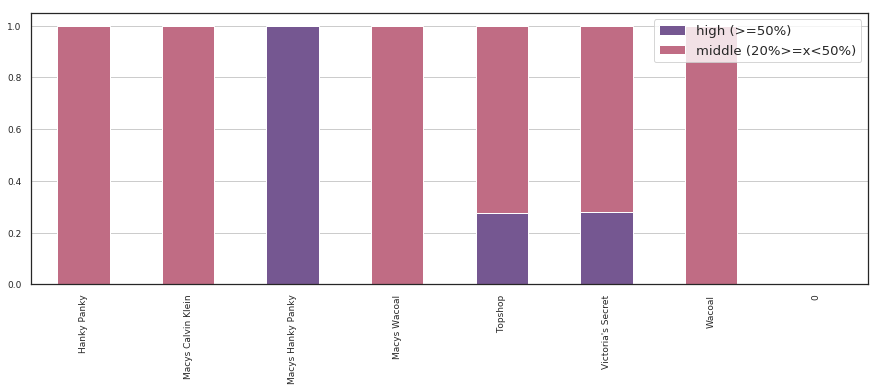

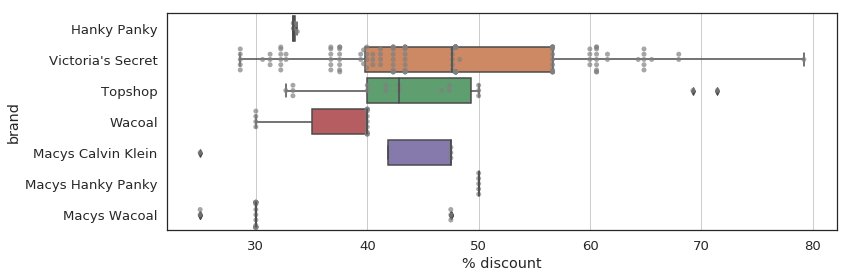

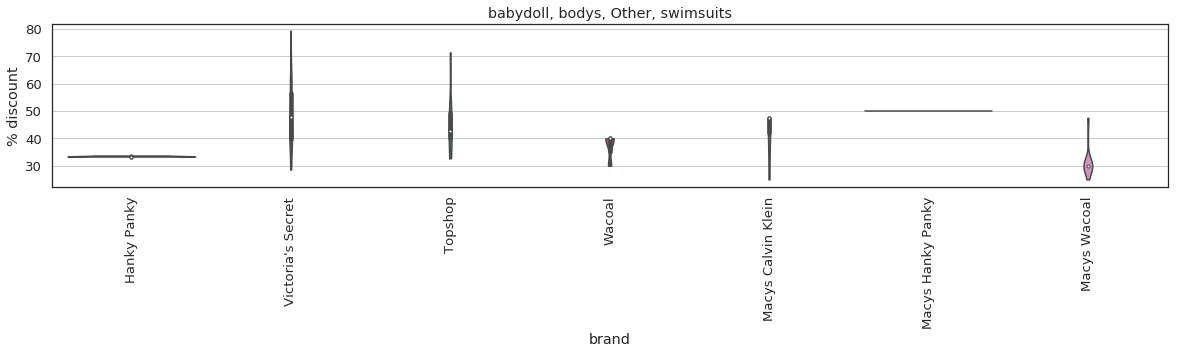

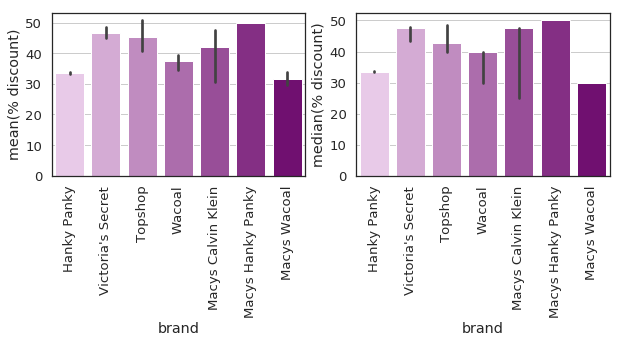

In [ ]:
cats = df['category'].unique()
cats = set(cats)- set(['panties', 'bras', 'activewear', 'bralettes', 'pack', 'sleepwear'])
#df1 = brands_info[brands_info['brand'].isin(brands)]
df1 = df[df['category'].isin(cats)]
stacked_all_brands(df1, discount_cat='diff_per_categories')

df1 = df[df['diff_per']>0]
category_plots(cats, df1, swarm = True, money = 'diff_per', xtitle = '% discount',
              figsize1=(12,4), figsize2=(20,3), figsize3=(10,3))

### Price comparison of Calvin Klein vs Victoria's Secret

brand   Calvin Klein  Victoria's Secret
median  16.99         12.99

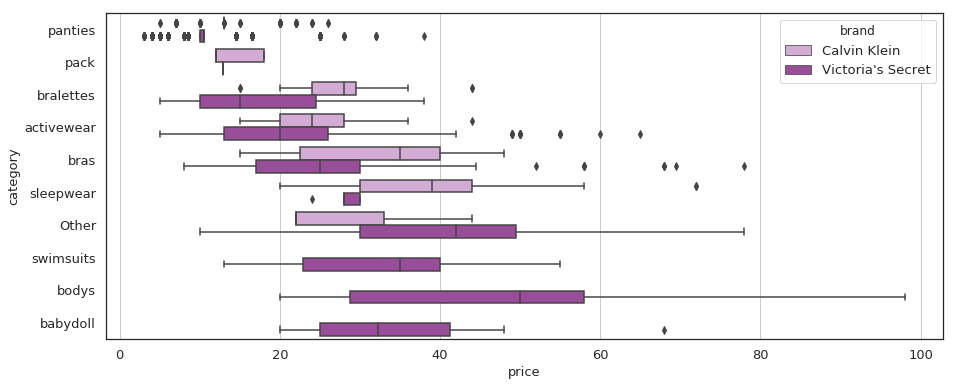

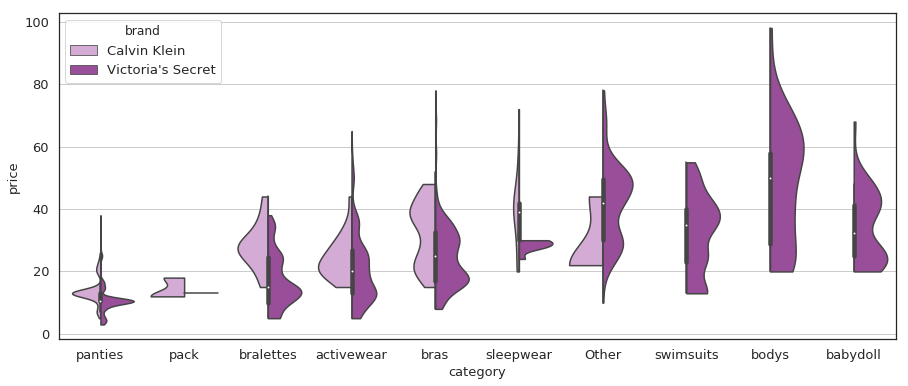

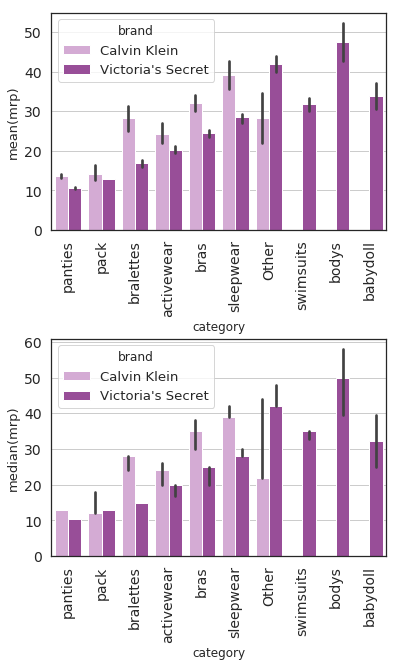

In [ ]:
df = brands_info[brands_info['brand'].isin(['Calvin Klein', "Victoria's Secret"])]
df = df[df['product_category']!='Other']
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,6))
ax = sns.boxplot(y = 'category', x="price", hue='brand', data=df, ax=axes, palette = [light_purple[2], light_purple[5]])
#ax = sns.swarmplot(y = 'category', hue = 'brand', x="mrp", data=df, ax = axes, color = 'grey')
_= ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel('price', fontsize=13)
ax.set_ylabel('category', fontsize=13)
ax.xaxis.grid(True)
fig.savefig('calvin_victoria_boxplot.png')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,6))
ax = sns.violinplot(y="price", hue ='brand', x = 'category',cut = 0, split=True, data=df, ax = axes, palette = [light_purple[2], light_purple[5]])
ax.yaxis.grid(True)
_= ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_ylabel('price', fontsize=13)
ax.set_xlabel('category', fontsize=13)
fig.savefig('calvin_victoria_violin.png')

barplots_extra('price', df, (6,10), hue = 'brand', x='category', palette = [light_purple[2], light_purple[5]])

In [ ]:
#brands_info.to_csv('data/final_data.csv')

*************

**I will be happy to hear remarks or comments :)**

**Have fun with the data!**
*************